In [48]:
from middoe.krnl_models import *
theta11, theta11max, theta11min = thetadic11()

In [49]:
system = {
    'tvi': {  # Time-variant input variables (models input: tvi), each key is a symbol nad key in tvi as well
        'T': {  # Temperature (K)
            'stps': 3,  # Number of switching times in CVPs (vector parametrisation resolution in time dimension):
            # Must be a positive integer > 1. swps-1 is the number of steps
            'const': 'dec',  # Constraint type: relative state of signal levels in CVPs
            # 'rel' (relative) ensures relaxation, 'dec' (decreasing) ensures decreasing signal levels, 'inc' (increasing) ensures increasing signal levels
            'max': 358.15,  # Maximum allowable signal level, des_opt space upper bound
            'min': 298.15,  # Minimum allowable signal level, des_opt space lower bound
            'cvp': 'LPF',  # Design CVP method (CPF - constant profile, LPF - linear profile)
            'offl': 5,  # minimum allowed perturbation of signal (ratio)
            'offt': 300  # minimum allowed perturbation of time (ratio)
        },
        'P': {  # Pressure (bar)
            'stps': 3,
            'const': 'rel',
            'max': 5,
            'min': 1,
            'cvp': 'CPF',
            'offl': 0.5,
            'offt': 300
        }
    },
    'tvo': {  # Time-variant output variables (responses, measured or unmeasured)
        'y1': {  # response variable, here carbonation efficiency
            'init': 0.001,  # Initial value for the response variable, it can be a value, or 'variable' for case it is a des_opt decision (time-invariant input variable)
            'meas': True,  # Flag indicating if this variable is directly measurable, if False, it is a virtual output
            'sp': 8,  # the amound of samples per each round (run)
            'unc': 0.02,  # amount of noise (standard deviation) in the measurement, in case of insilico, this is used for simulating a normal distribution of noise to measurement (only measurement)
            'offt': 300,  # minimum allowed perturbation of sampling times (ratio)
            'samp_s': 1,  # Matching criterion for models prediction and data alignment
            'samp_f': [0, 10800],  # fixed sampling times
        }
    },
    'tii': {  # Time-invariant input variables (tii)
            'aps': {'max': 1.5e-4, 'min': 8e-6},
    },
    'tio': {  # Time-invariant output variables (empty here, could hold steady state responses that hold no dependency)
    },
    't_s': [0, 10800],  # Time span  (600 s to 10,800 s), duration of numerical perturbations (the rest is precluded from des_opt)
    't_r': 30,  # Time resolution (10 s), minimum time steps for the simulation/des_opt/controls
    't_d': 600
}

In [50]:
models = { # Settings related to the rival models and their parameters
    'can_m': ['f11'],  # Active solvers (rival models) to be used in the experiment
    'krt': {'f11':f11},  # Kernel functions for the models
    # type of the model interface, 'pym' for middoe.krnl_models, 'gpr' for gPAS models, function name for globally defined functions, 'pys' for python standalone scripts
    'creds': {'f20': '@@TTmnoa698'},
    # credentials for gPAS models, if not needed, leave empty
    'src': {'f20': 'C:/Users/Tadmin/PycharmProjects/tutorialmid1/semiconwet/ipy/model_semiconwet.py'},

    # for now for gPAS readable files, or python standalone scripts

    'theta': { # Theta parameters for each models
        'f11': theta11
    },
    't_u': { # Maximum bounds for theta parameters (based on normalized to'f20': theta20mins, 1)
        'f11': theta11max
    },
    't_l': { # Minimum bounds for theta parameters (based on normalized to 1)
        'f11': theta11min
    },
}

In [51]:
gsa = { # Settings for the Global Sensitivity Analysis (gsa)
    'var_s': True,  # Perform sensitivity analysis for variables
    'par_s': False,  # Perform sensitivity analysis for parameters
    'var_d': False, # feasible space for variables, fload ratio: use as multiplier to nominals uniformly (e.g. 1.1), False: use system defined space
    'par_d': False,   # feasible space for parameters, fload ratio: use as multiplier to nominals uniformly(e.g. 1.1), False: use models defined space
    'samp': 2 ** 6,  # Sampling size for gsa, always 2**n
    'multi': 0.7,  # Perform gsa in parallel
    'tii_n': [5.5e-5], # Nominal values for the time-invariant variables
    'tvi_n': [293.15, 1], # Nominal values for the time-variant variables
    'plt': True,  # Plot the results
}

Running GSA-Sobol for model: f11 in parallel


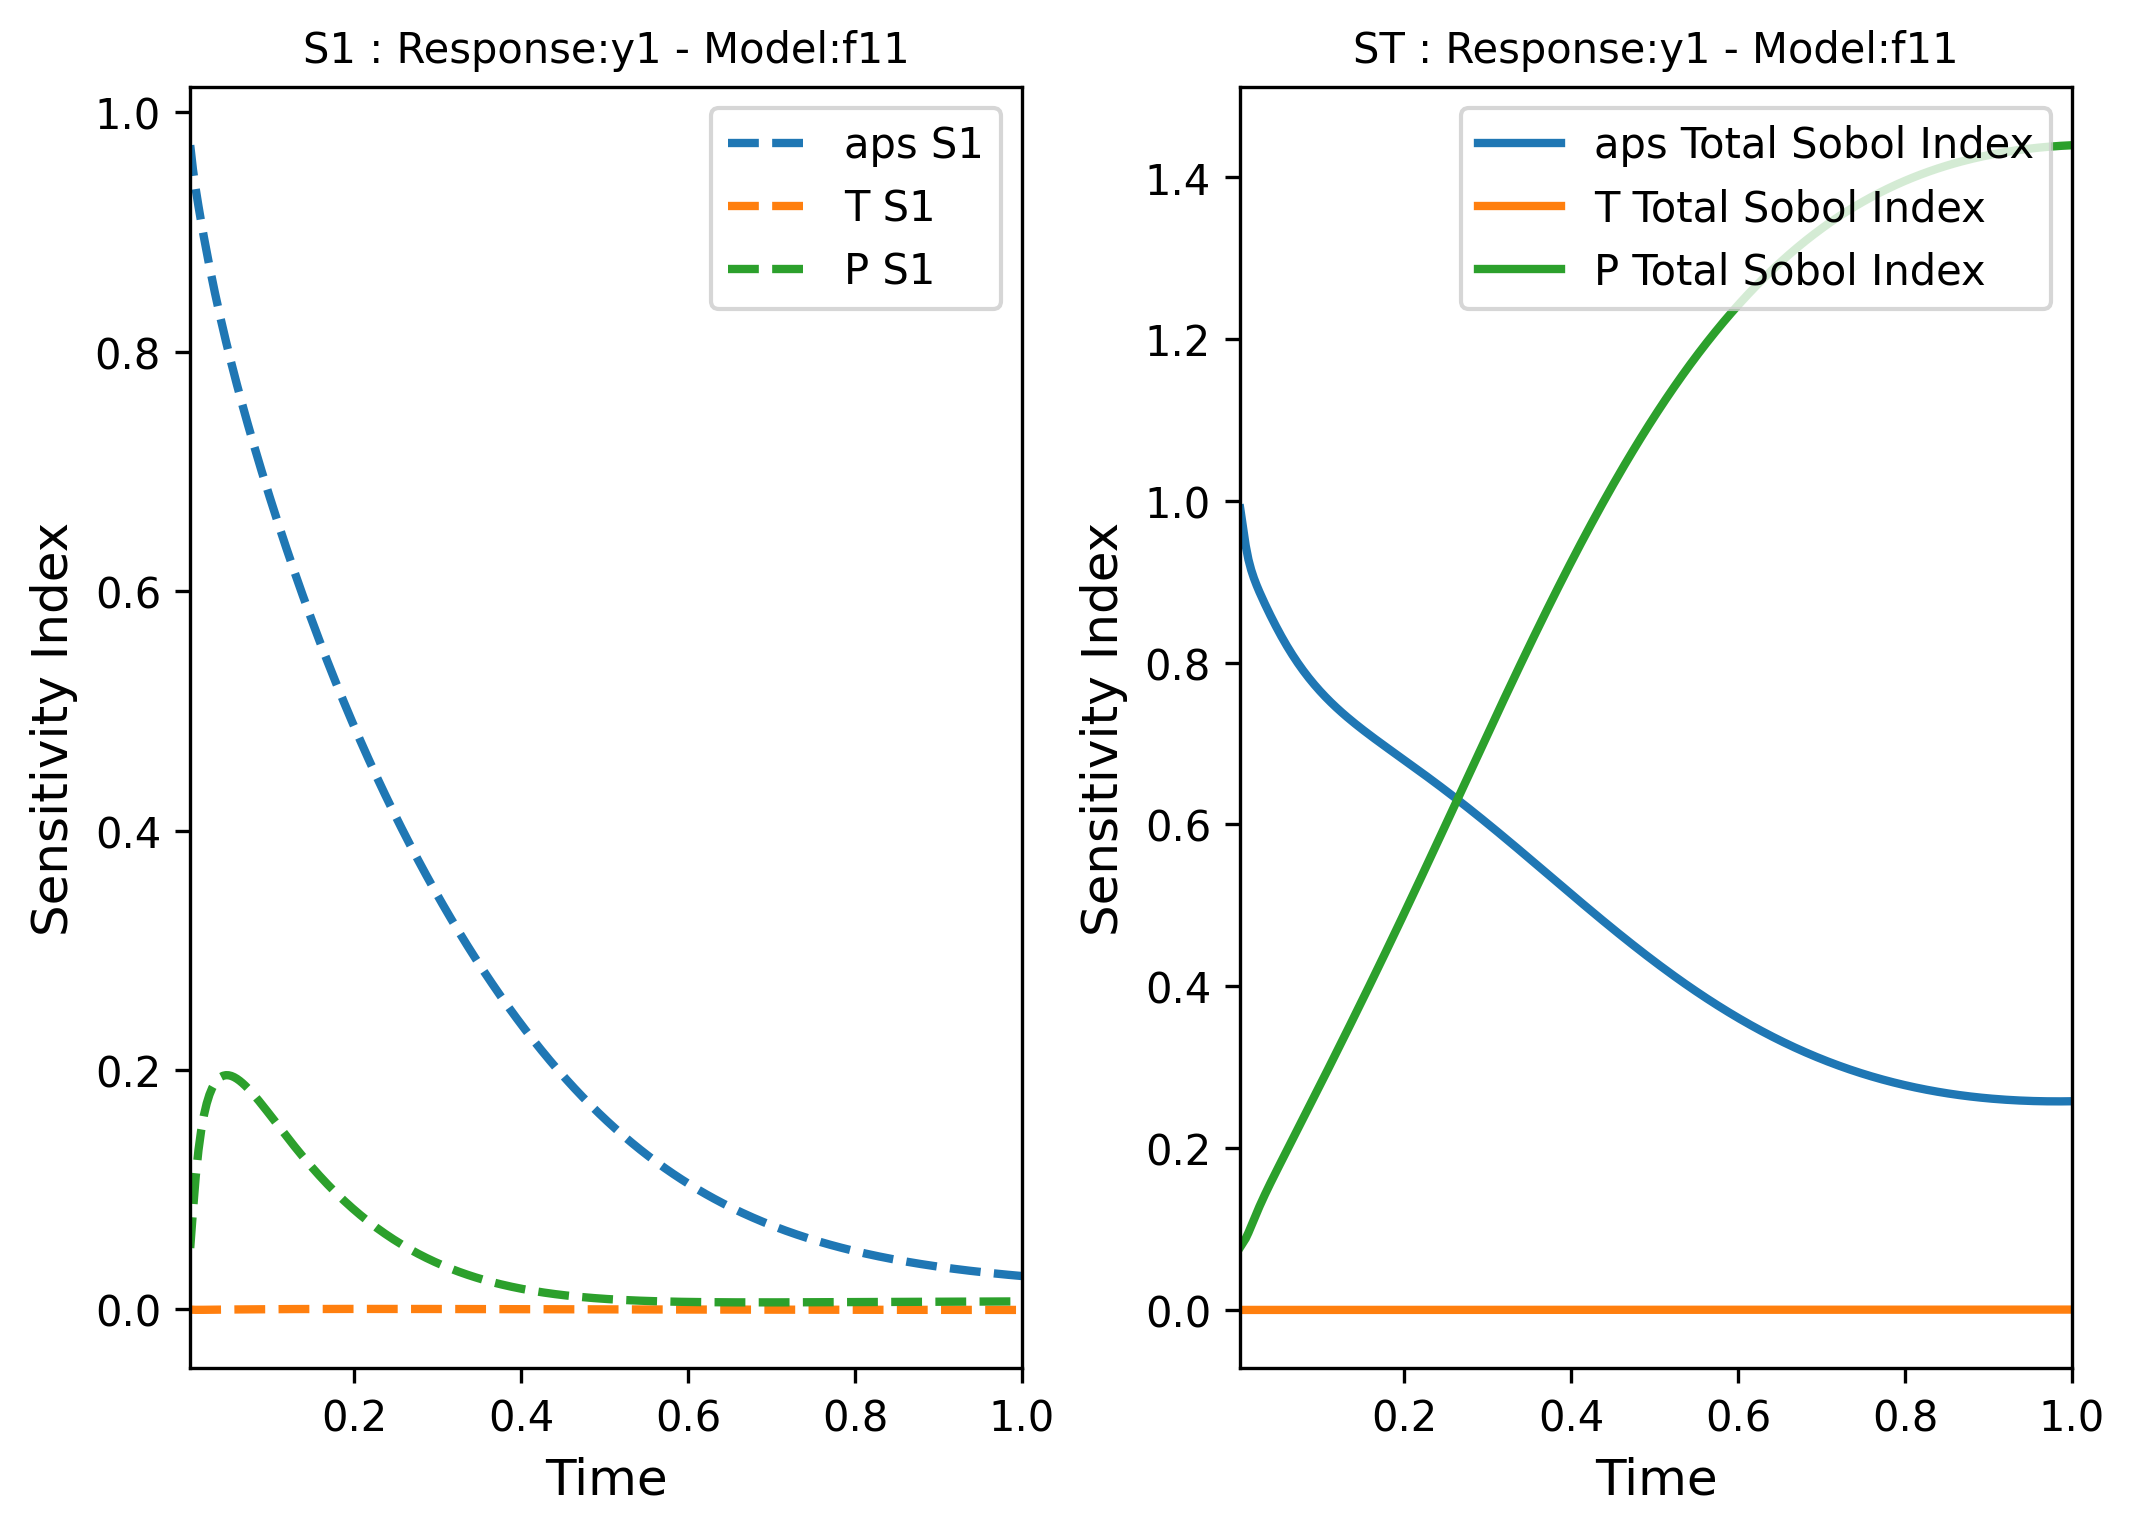

In [52]:
from middoe.sc_sensa import sensa
sobol_results = sensa(gsa, models, system)

In [55]:
gsa = { # Settings for the Global Sensitivity Analysis (gsa)
    'var_s': False,  # Perform sensitivity analysis for variables
    'par_s': True,  # Perform sensitivity analysis for parameters
    'var_d': False, # feasible space for variables, fload ratio: use as multiplier to nominals uniformly (e.g. 1.1), False: use system defined space
    'par_d': 1.2,   # feasible space for parameters, fload ratio: use as multiplier to nominals uniformly(e.g. 1.1), False: use models defined space
    'samp': 2 ** 6,  # Sampling size for gsa, always 2**n
    'multi': 0.7,  # Perform gsa in parallel
    'tii_n': [5.5e-5], # Nominal values for the time-invariant variables
    'tvi_n': [293.15, 1], # Nominal values for the time-variant variables
    'plt': True,  # Plot the results
}

Running GSA-Sobol for model: f11 in parallel


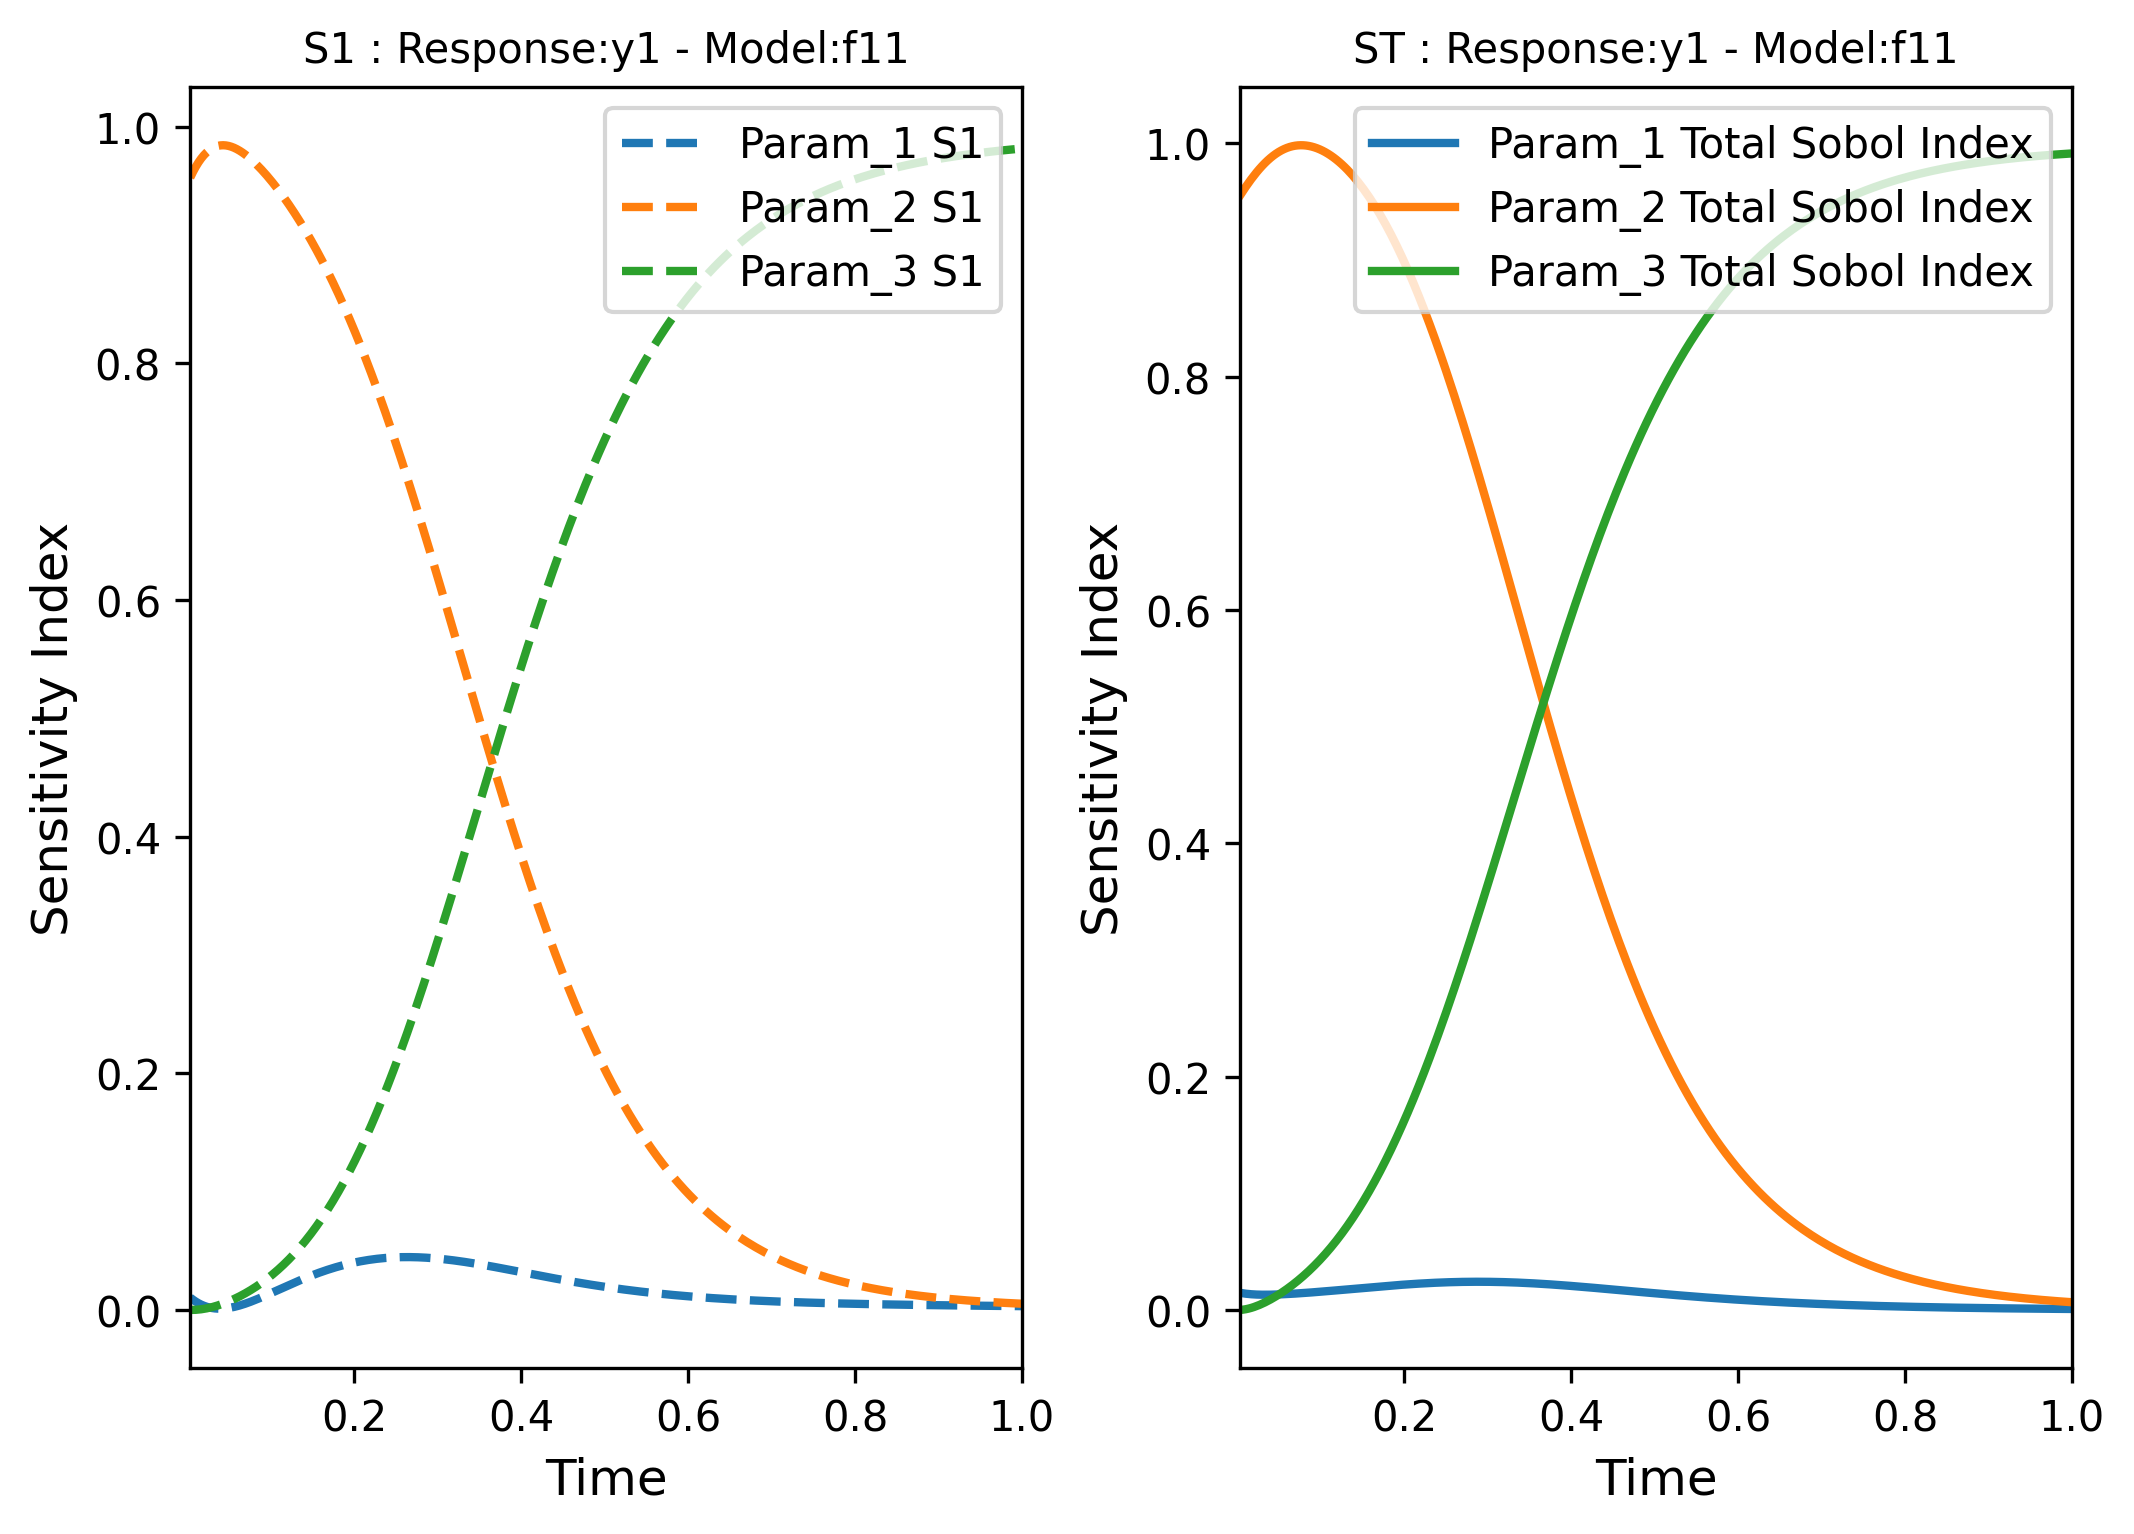

In [56]:
from middoe.sc_sensa import sensa
sobol_results2 = sensa(gsa, models, system)

In [57]:
from middoe.log_utils import save_to_jac
save_to_jac(sobol_results2, purpose="sensa")

[INFO] Results saved to: C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\sensa_results.jac


In [58]:
from middoe.log_utils import load_from_jac, save_to_xlsx

results = load_from_jac()
sensa = results['sensa']
save_to_xlsx(sensa)

File not found: iden_results.jac
Loaded: sensa_results.jac
Sobol results saved to: C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\sobol_results.xlsx


In [59]:
insilicos = { # Settings for the insilico data generation
    'tr_m': 'f11', # selected true models (with nominal values)
    'prels': { # classic des_opt settings, sheet name is the round run name, each sheet contains the data for the round, iso space.
        '1': {'T': 293.15, 'P': 1, 'aps': 5.5e-5},
        '2': {'T': 313.15, 'P': 1, 'aps': 5.5e-5},
        # '3': {'T': 338.15, 'P': 0.17, 'aps': 350, 'slr': 0.1},
        # '4': {'T': 353.15, 'P': 1, 'rho': 3191, 'cac': 44.93, 'aps': 5.5e-5, 'mld': 36000}
    }
}

In [60]:
from middoe.krnl_expera import expera
expera(system, models, insilicos, design_decisions={}, expr=1)


[✓] In-silico data saved to: C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\indata.xlsx
[INFO] Model used         : f11
[INFO] Design case        : classic/preliminary
[INFO] Responses simulated:
   - y1         | measurable      | std.dev = 0.02


(WindowsPath('C:/Users/Tadmin/PycharmProjects/tutorialmid1/wetcarbokin/ipy/indata.xlsx'),
      MES_X:y1  MES_Y:y1    X:all       aps       T    P   CVP:T   CVP:P
 0         0.0  0.000996      0.0  0.000055  293.15  1.0  no_CVP  no_CVP
 1      1530.0  0.845859     30.0  0.000055  293.15  1.0     NaN     NaN
 2      3090.0  0.901530     60.0  0.000055  293.15  1.0     NaN     NaN
 3      4620.0  0.945744     90.0  0.000055  293.15  1.0     NaN     NaN
 4      6180.0  0.901902    120.0  0.000055  293.15  1.0     NaN     NaN
 ..        ...       ...      ...       ...     ...  ...     ...     ...
 356       NaN       NaN  10680.0  0.000055  293.15  1.0     NaN     NaN
 357       NaN       NaN  10710.0  0.000055  293.15  1.0     NaN     NaN
 358       NaN       NaN  10740.0  0.000055  293.15  1.0     NaN     NaN
 359       NaN       NaN  10770.0  0.000055  293.15  1.0     NaN     NaN
 360       NaN       NaN  10800.0  0.000055  293.15  1.0     NaN     NaN
 
 [361 rows x 8 columns])

In [61]:
from middoe.krnl_expera import expera
expera(system, models, insilicos, design_decisions={}, expr=2)


[✓] In-silico data saved to: C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\indata.xlsx
[INFO] Model used         : f11
[INFO] Design case        : classic/preliminary
[INFO] Responses simulated:
   - y1         | measurable      | std.dev = 0.02


(WindowsPath('C:/Users/Tadmin/PycharmProjects/tutorialmid1/wetcarbokin/ipy/indata.xlsx'),
      MES_X:y1  MES_Y:y1    X:all       aps       T    P   CVP:T   CVP:P
 0         0.0  0.001011      0.0  0.000055  313.15  1.0  no_CVP  no_CVP
 1      1530.0  0.875727     30.0  0.000055  313.15  1.0     NaN     NaN
 2      3090.0  0.892714     60.0  0.000055  313.15  1.0     NaN     NaN
 3      4620.0  0.932749     90.0  0.000055  313.15  1.0     NaN     NaN
 4      6180.0  0.886815    120.0  0.000055  313.15  1.0     NaN     NaN
 ..        ...       ...      ...       ...     ...  ...     ...     ...
 356       NaN       NaN  10680.0  0.000055  313.15  1.0     NaN     NaN
 357       NaN       NaN  10710.0  0.000055  313.15  1.0     NaN     NaN
 358       NaN       NaN  10740.0  0.000055  313.15  1.0     NaN     NaN
 359       NaN       NaN  10770.0  0.000055  313.15  1.0     NaN     NaN
 360       NaN       NaN  10800.0  0.000055  313.15  1.0     NaN     NaN
 
 [361 rows x 8 columns])

In [62]:
iden_opt = { # Settings for the parameter estimation process
    'meth': 'Ls',  # optimisation method, 'G': Global Differential Evolution, 'Ls': Local SLSQP, 'Ln': Local Nelder-Mead
    'init': None,   # use 'rand' to have random starting point and use None to start from theta_parameters nominal values (to be avoided in insilico studies)
    'eps': 1e-3,  # perturbation size of parameters in SA FDM method (in a normalized to 1 space)
    #usually 1e-3, or None to perform a mesh independency test, and auto adjustment
    'ob': 'LS',  #loss function, 'LS': least squares, 'MLE': maximum likelihood, 'Chi': chi-square, 'WLS': weighted least squares
    'c_plt': True, # plot the confidence volumes
    'f_plt': True, # plot the fitting results
    'plt_s': True, # show plots while saving
    'log': True # log the results
}

In [63]:
from middoe.log_utils import  read_excel
data = read_excel('indata')

[INFO] Reading from indata.xlsx


In [64]:
from middoe.iden_parmest import parmest
resultpr = parmest(system, models, iden_opt, data)

Objective function: 'LS'| model 'f11' | CPU time 0.0495 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0439 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0455 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0430 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0405 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0441 seconds.
parameter estimation for model f11 concluded- success: True



In [65]:
from middoe.iden_uncert import uncert
uncert_results = uncert(data, resultpr, system, models, iden_opt)
resultun = uncert_results['results']
theta_parameters = uncert_results['theta_parameters']
solver_parameters = uncert_results['solver_parameters']
scaled_params = uncert_results['scaled_params']
obs = uncert_results['obs']


Estimated parameters of f11: [3.163724034002779e-07, 20310.49401336971, 1.220249269509001]
True parameters of f11: [3.1650075431484574e-07, 20239.398294836665, 1.2133668813455163]
LS objective function value for f11: 0.997037668314706
T-values of model f11: [ 0.13012883  1.05806323 38.98851764]
P-value of model:f11 is 100.0 for model discrimination
R2 values for responses in model f11:
  y1: 0.9970


In [ ]:
from middoe.sc_estima import estima
j = 2
ranking, k_optimal_value, rCC_values, J_k_values = estima(resultun, system, models, iden_opt, j, data)

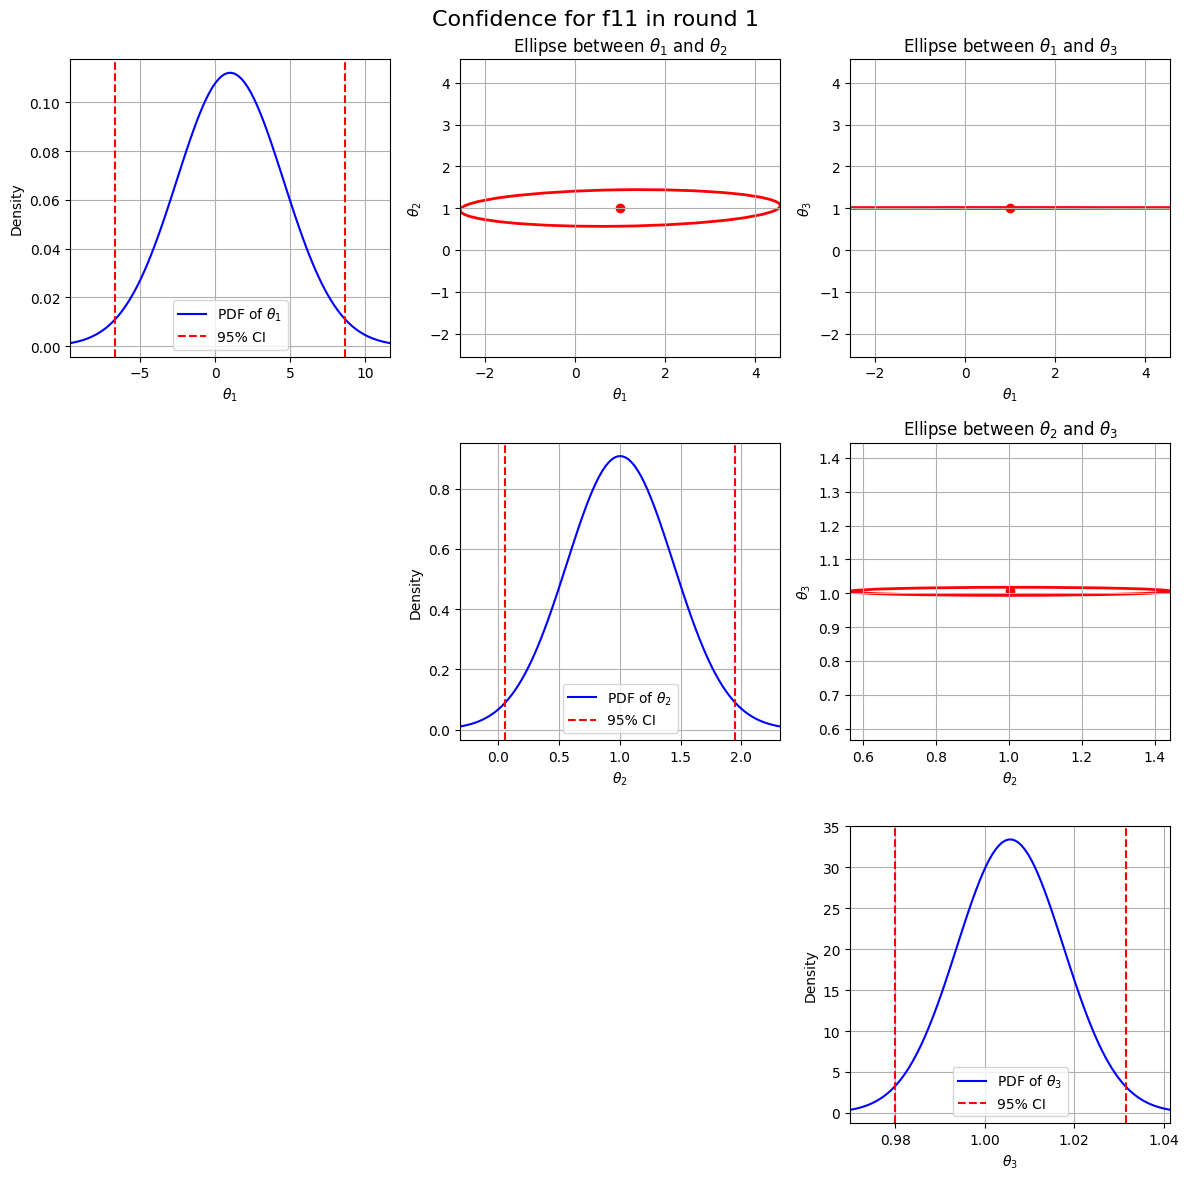

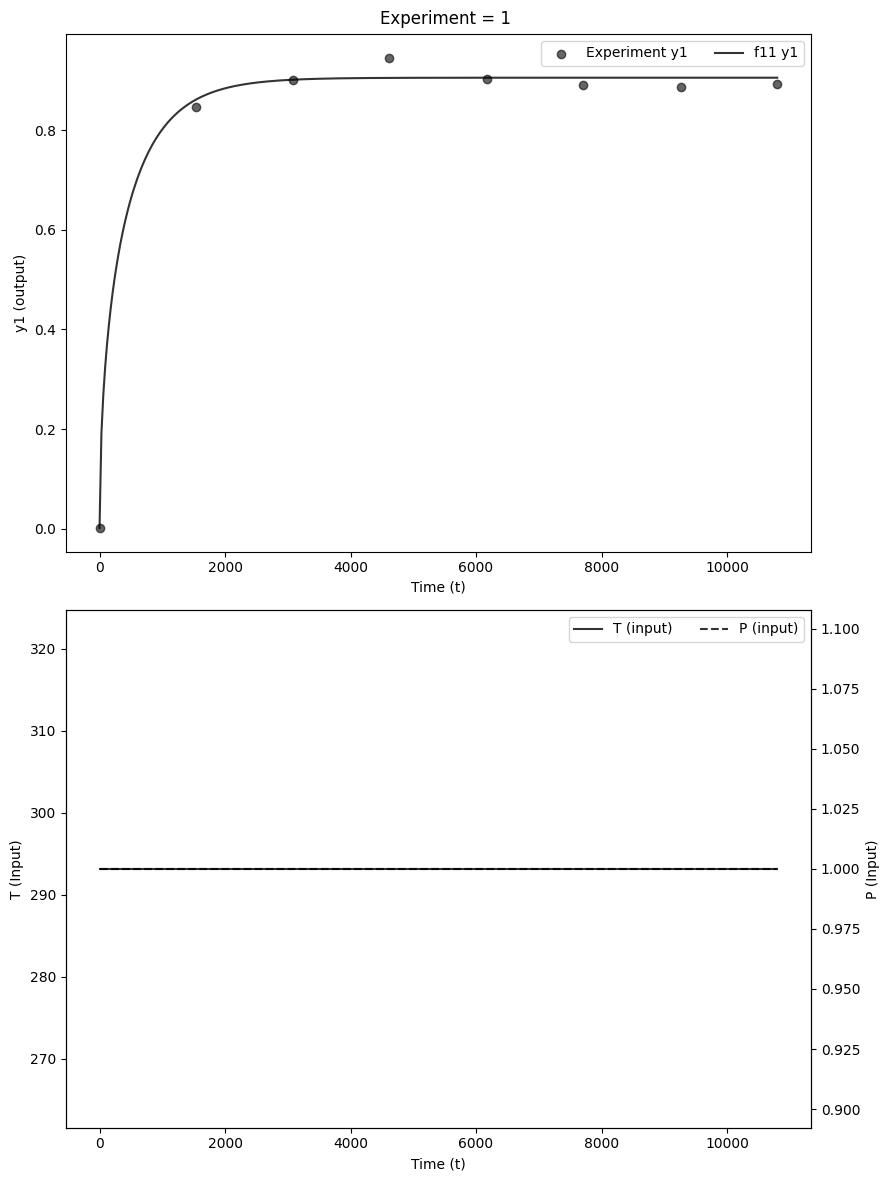

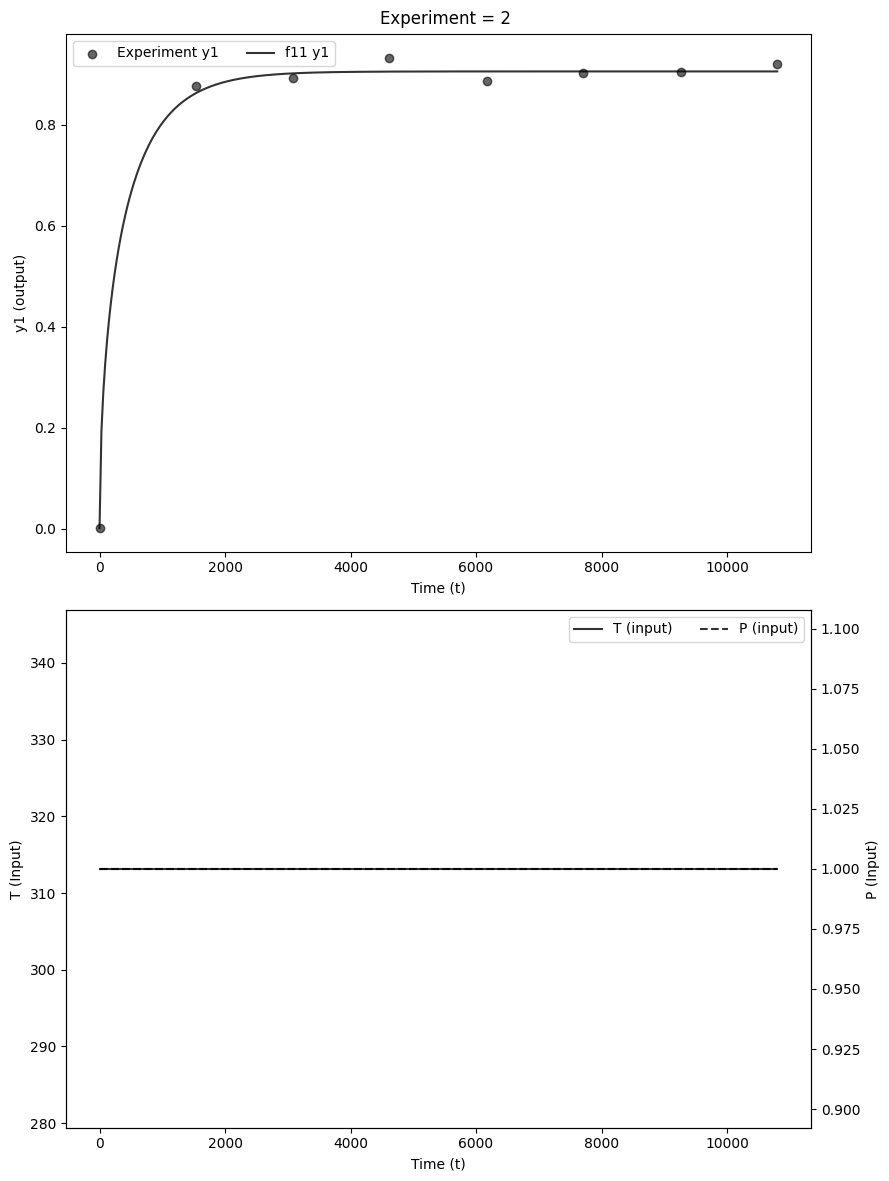

reference t value for model f11 and round 1: 2.1603686564610127
estimated t values for model f11 and round 1: [ 0.13012883  1.05806323 38.98851764]
P-value for model f11 and round 1: 100.0
eps for model f11 and round 1: 0.001



{'f11': np.float64(2.1603686564610127)}

In [66]:
from middoe.log_utils import  read_excel, save_rounds
round_data={}
round = 1
save_rounds(round, resultun, theta_parameters, 'preliminary', round_data, models, scaled_params,iden_opt,solver_parameters, obs, data, system)

In [67]:
des_opt = { # Design settings for the experiment
    'eps': 1e-3, #perturbation size of parameters in SA FDM method (in a normalized to 1 space)
    'md_ob': 'HR',     # MD optimality criterion, 'HR': Hunter and Reiner, 'BFF': Buzzi-Ferraris and Forzatti
    'pp_ob': 'E',  # PP optimality criterion, 'D', 'A', 'E', 'ME'
    'plt': True,  # Plot the results
    'itr': {
        'pps': 50, # population size
        'maxmd': 10, # maximum number of MD runs
        'tolmd': 1, # tolerance for MD optimization
        'maxpp':10 ,# maximum number of PP runs
        'tolpp': 1, # tolerance for PP optimization
    }
}

In [68]:
from middoe.des_pp import mbdoe_pp
designs = mbdoe_pp(des_opt, system, models, round=2, num_parallel_runs=20)

In [69]:
expera(system, models, insilicos, designs, expr=3, swps=designs['swps'])


[✓] In-silico data saved to: C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\indata.xlsx
[INFO] Model used         : f11
[INFO] Design case        : MBDoE
[INFO] Responses simulated:
   - y1         | measurable      | std.dev = 0.02


(WindowsPath('C:/Users/Tadmin/PycharmProjects/tutorialmid1/wetcarbokin/ipy/indata.xlsx'),
      MES_X:y1  MES_Y:y1    X:all       aps           T         P       CVP:T  \
 0         0.0  0.000972      0.0  0.000106  338.195799  1.649977  None   LPF   
 1       900.0  0.631592     30.0  0.000106  338.154051  1.649977  None   NaN   
 2      2220.0  0.780247     60.0  0.000106  338.112304  1.649977  None   NaN   
 3      3120.0  0.838814     90.0  0.000106  338.070556  1.649977  None   NaN   
 4      6120.0  0.863958    120.0  0.000106  338.028809  1.649977  None   NaN   
 ..        ...       ...      ...       ...         ...       ...   ...   ...   
 356       NaN       NaN  10680.0  0.000106  302.460188  4.234945  None   NaN   
 357       NaN       NaN  10710.0  0.000106  302.460188  4.234945  None   NaN   
 358       NaN       NaN  10740.0  0.000106  302.460188  4.234945  None   NaN   
 359       NaN       NaN  10770.0  0.000106  302.460188  4.234945  None   NaN   
 360       NaN     

In [70]:
data = read_excel('indata')

[INFO] Reading from indata.xlsx


In [71]:
resultpr = parmest(system, models, iden_opt, data)

Objective function: 'LS'| model 'f11' | CPU time 0.0647 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0604 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0601 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0605 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0711 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0640 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0578 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0600 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0688 seconds.
parameter estimation for model f11 concluded- success: True



In [72]:
uncert_results = uncert(data, resultpr, system, models, iden_opt)
resultun = uncert_results['results']
theta_parameters = uncert_results['theta_parameters']
solver_parameters = uncert_results['solver_parameters']
scaled_params = uncert_results['scaled_params']
obs = uncert_results['obs']

Estimated parameters of f11: [3.163217668307586e-07, 20325.054802480223, 1.2164866873577476]
True parameters of f11: [3.1650075431484574e-07, 20239.398294836665, 1.2133668813455163]
LS objective function value for f11: 0.996885381914982
T-values of model f11: [ 0.49293314  3.61092314 42.34668192]
P-value of model:f11 is 100.0 for model discrimination
R2 values for responses in model f11:
  y1: 0.9969


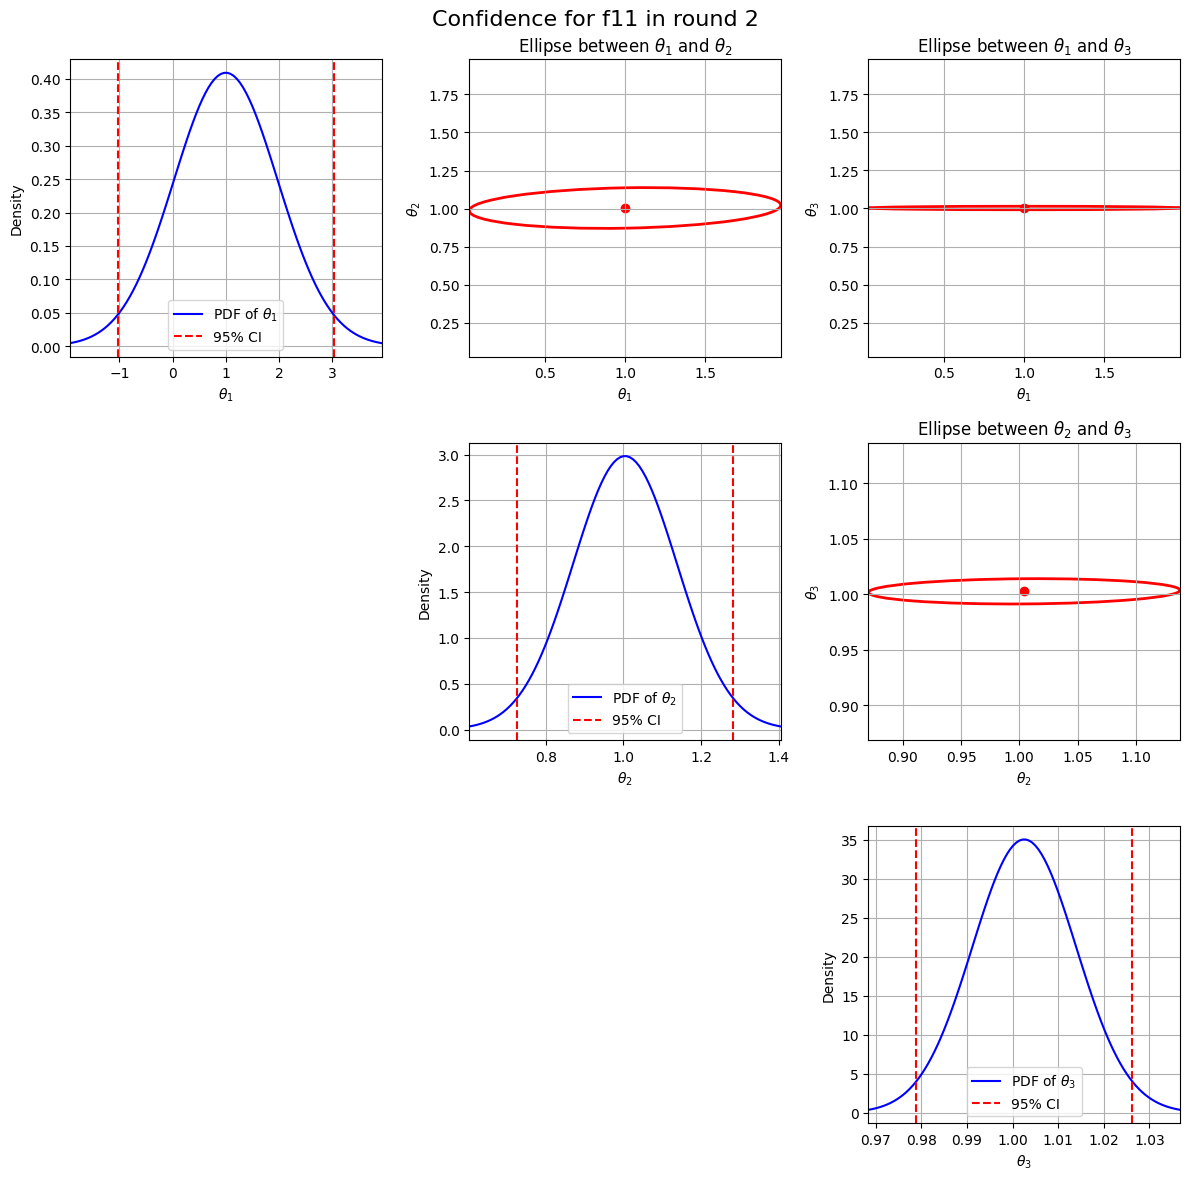

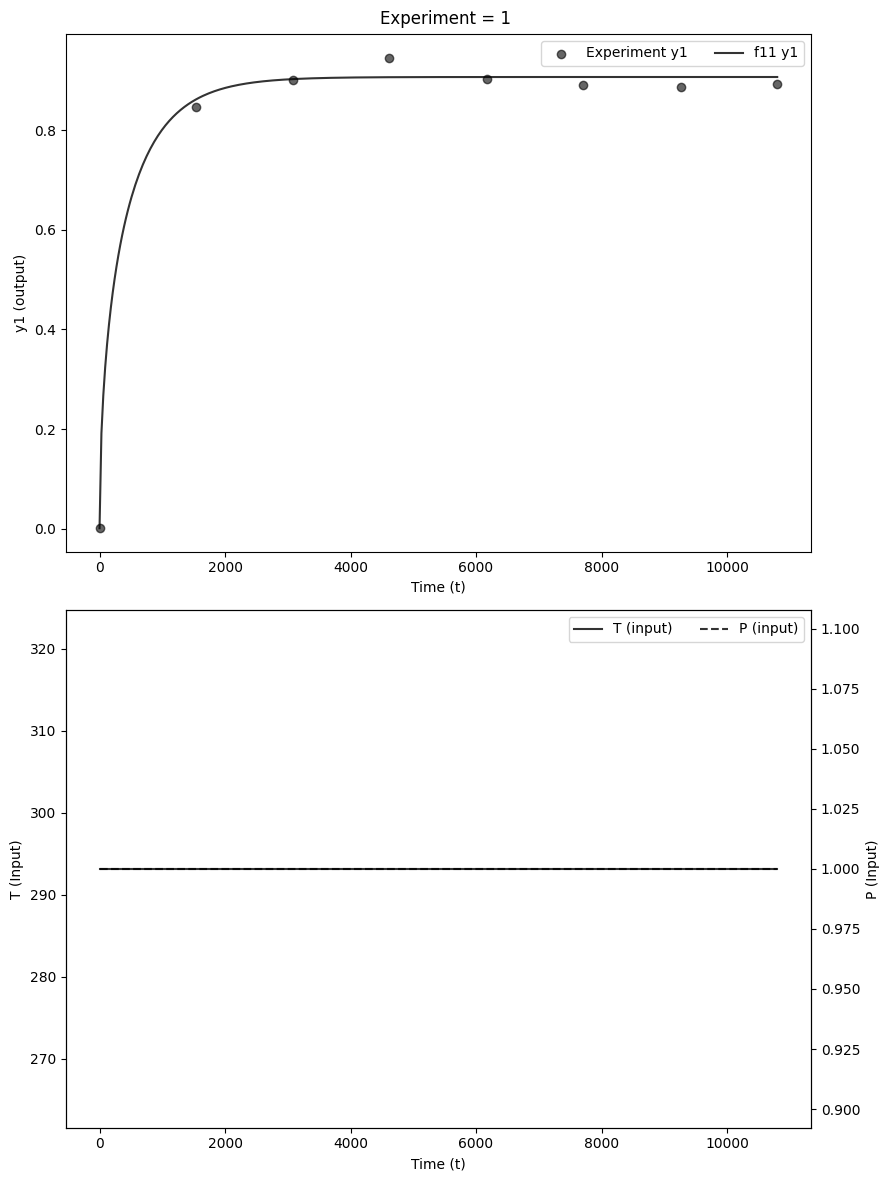

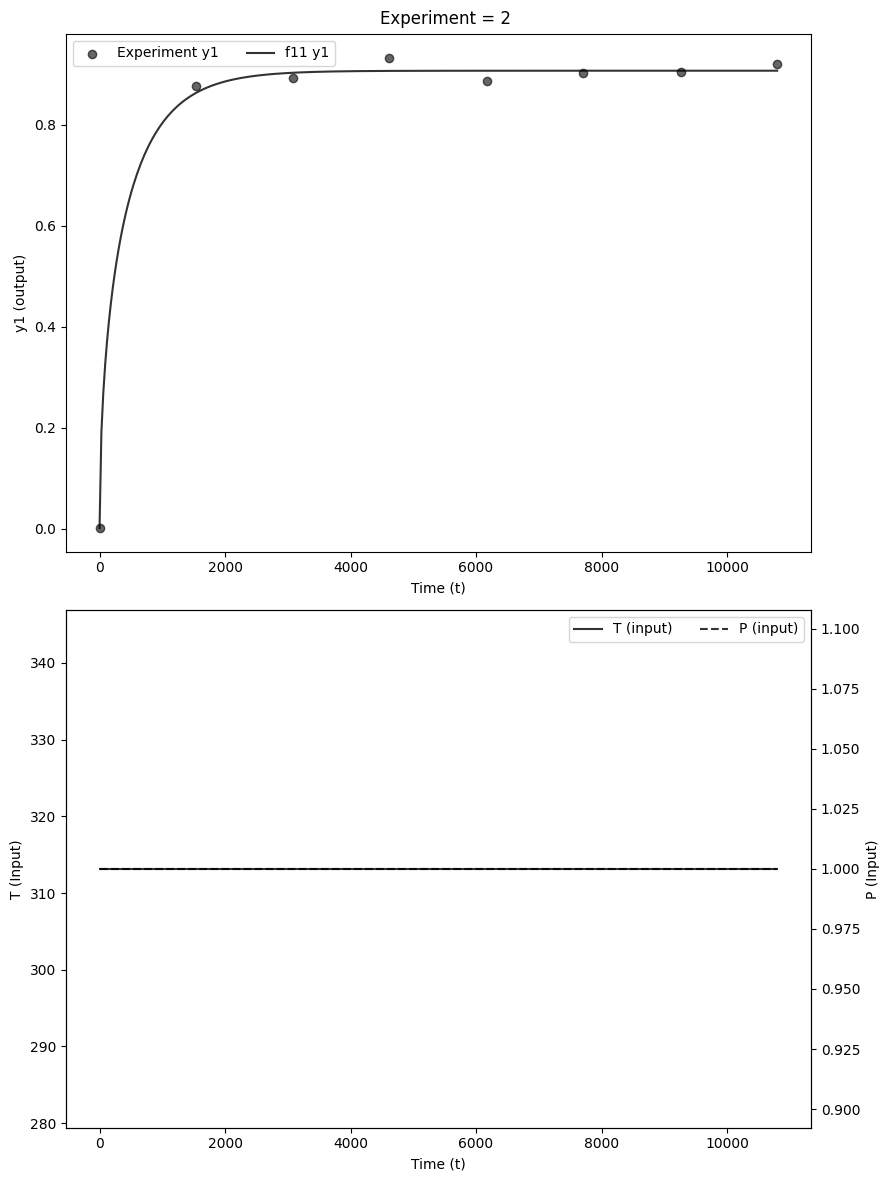

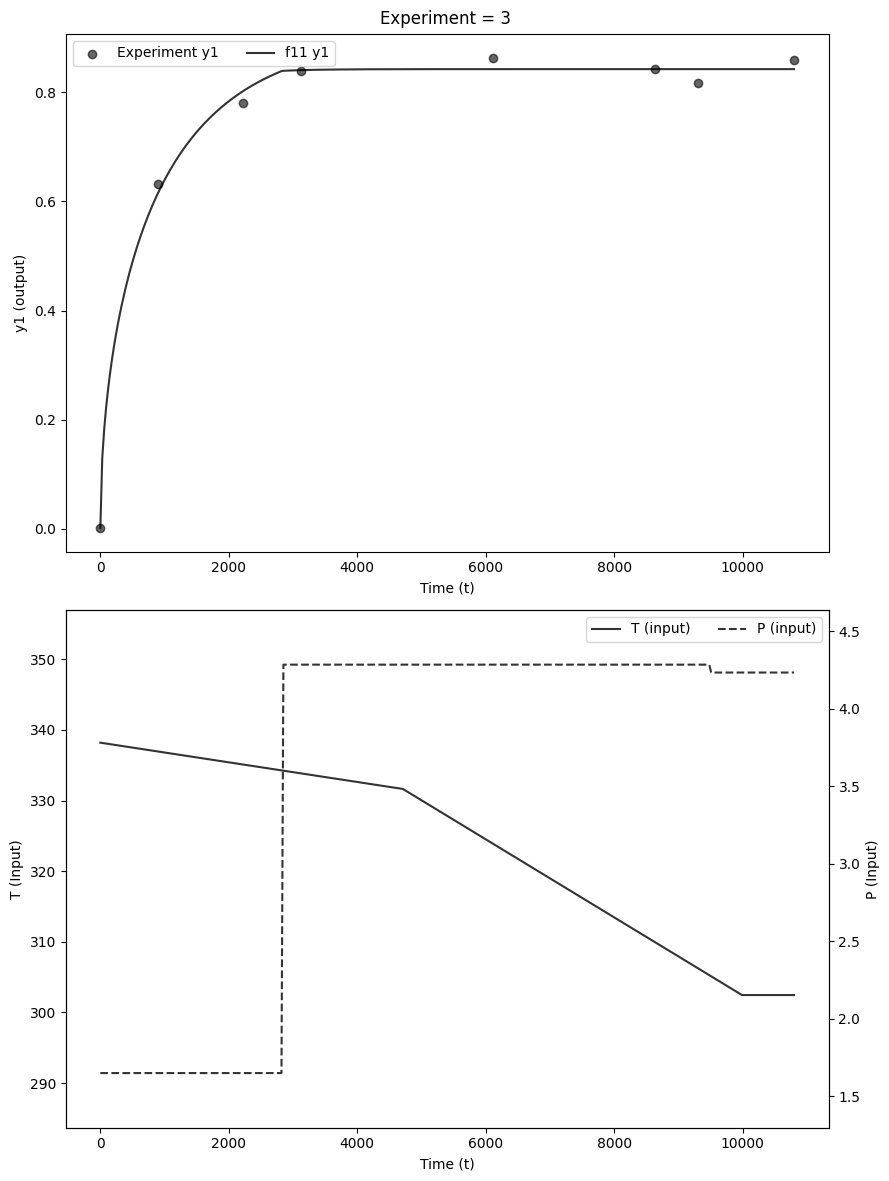

reference t value for model f11 and round 2: 2.079613844727662
estimated t values for model f11 and round 2: [ 0.49293314  3.61092314 42.34668192]
P-value for model f11 and round 2: 100.0
eps for model f11 and round 2: 0.001



{'f11': np.float64(2.079613844727662)}

In [73]:
round = 2
save_rounds(round, resultun, theta_parameters, 'MBDOE_PP', round_data, models, scaled_params, iden_opt,
            solver_parameters, obs, data, system)

In [75]:
from middoe.des_pp import mbdoe_pp
designs2 = mbdoe_pp(des_opt, system, models, round=3, num_parallel_runs=20)

In [76]:
expera(system, models, insilicos, designs2, expr=4, swps=designs2['swps'])


[✓] In-silico data saved to: C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\indata.xlsx
[INFO] Model used         : f11
[INFO] Design case        : MBDoE
[INFO] Responses simulated:
   - y1         | measurable      | std.dev = 0.02


(WindowsPath('C:/Users/Tadmin/PycharmProjects/tutorialmid1/wetcarbokin/ipy/indata.xlsx'),
      MES_X:y1  MES_Y:y1    X:all       aps           T         P       CVP:T  \
 0         0.0  0.000996      0.0  0.000124  335.147015  1.345498  None   LPF   
 1      3480.0  0.829853     30.0  0.000124  334.905008  1.345498  None   NaN   
 2      4500.0  0.825756     60.0  0.000124  334.663001  1.345498  None   NaN   
 3      6180.0  0.806663     90.0  0.000124  334.420994  1.345498  None   NaN   
 4      7380.0  0.833899    120.0  0.000124  334.178987  1.345498  None   NaN   
 ..        ...       ...      ...       ...         ...       ...   ...   ...   
 356       NaN       NaN  10680.0  0.000124  322.424703  1.361683  None   NaN   
 357       NaN       NaN  10710.0  0.000124  322.424703  1.361683  None   NaN   
 358       NaN       NaN  10740.0  0.000124  322.424703  1.361683  None   NaN   
 359       NaN       NaN  10770.0  0.000124  322.424703  1.361683  None   NaN   
 360       NaN     

In [77]:
data = read_excel('indata')

[INFO] Reading from indata.xlsx


In [78]:
resultpr = parmest(system, models, iden_opt, data)

Objective function: 'LS'| model 'f11' | CPU time 0.0946 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0857 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0871 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0955 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0959 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.1001 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.1095 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0922 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0867 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0981 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0927 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0793 seconds.
parameter estimation for model f11 concluded- success: True



In [79]:
uncert_results = uncert(data, resultpr, system, models, iden_opt)
resultun = uncert_results['results']
theta_parameters = uncert_results['theta_parameters']
solver_parameters = uncert_results['solver_parameters']
scaled_params = uncert_results['scaled_params']
obs = uncert_results['obs']

Estimated parameters of f11: [3.1755009874673654e-07, 20180.43638979454, 1.2241702329106021]
True parameters of f11: [3.1650075431484574e-07, 20239.398294836665, 1.2133668813455163]
LS objective function value for f11: 0.9967490963117867
T-values of model f11: [ 0.47818565  3.47764419 46.62907579]
P-value of model:f11 is 100.0 for model discrimination
R2 values for responses in model f11:
  y1: 0.9968


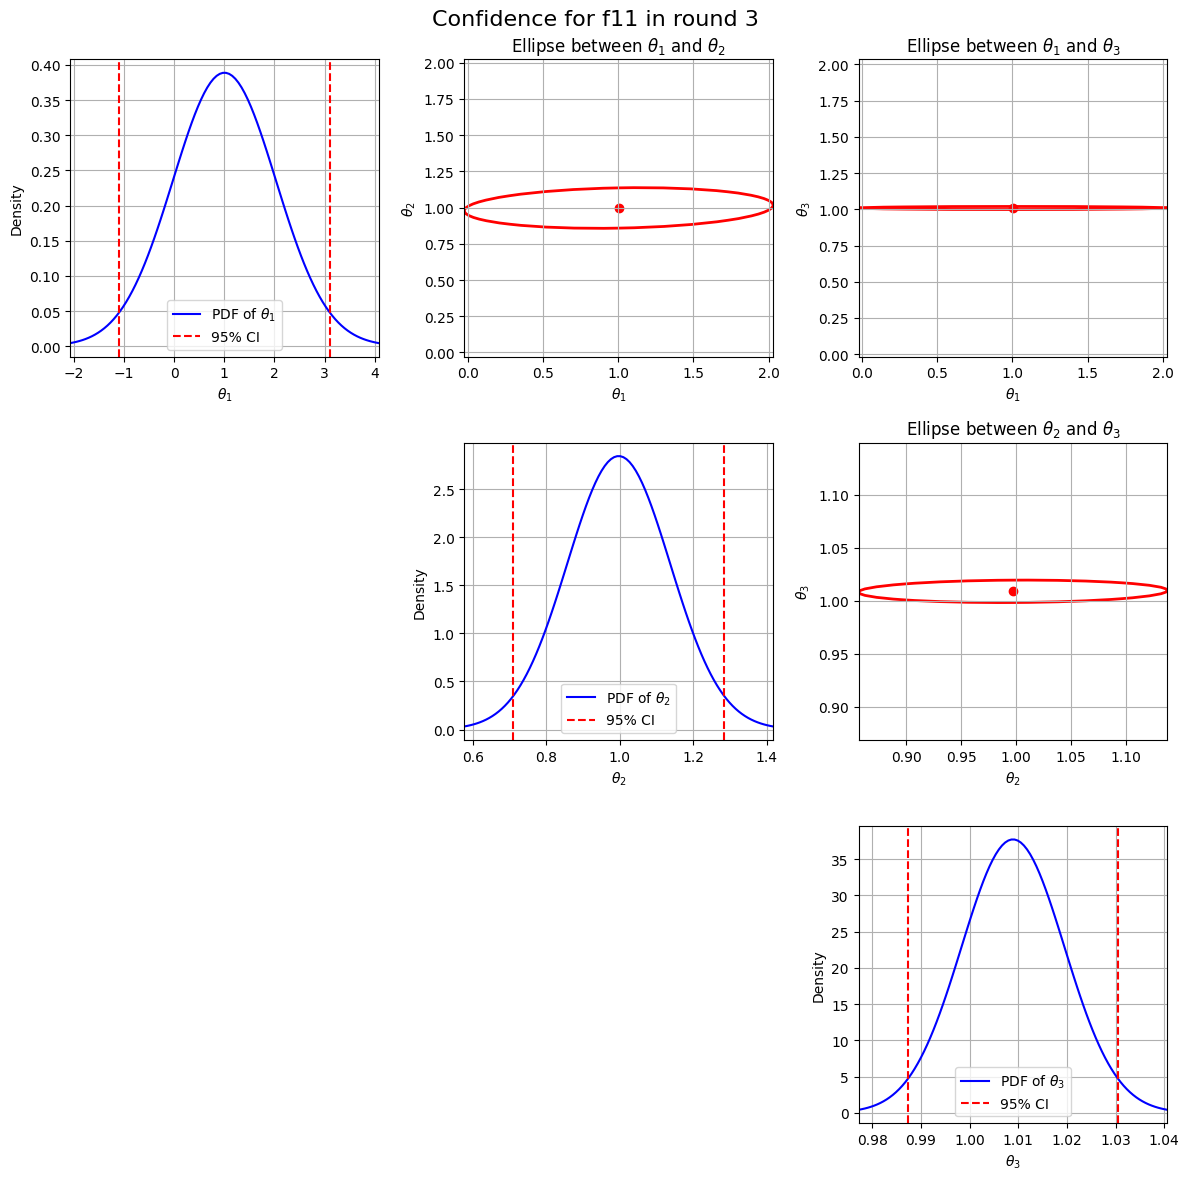

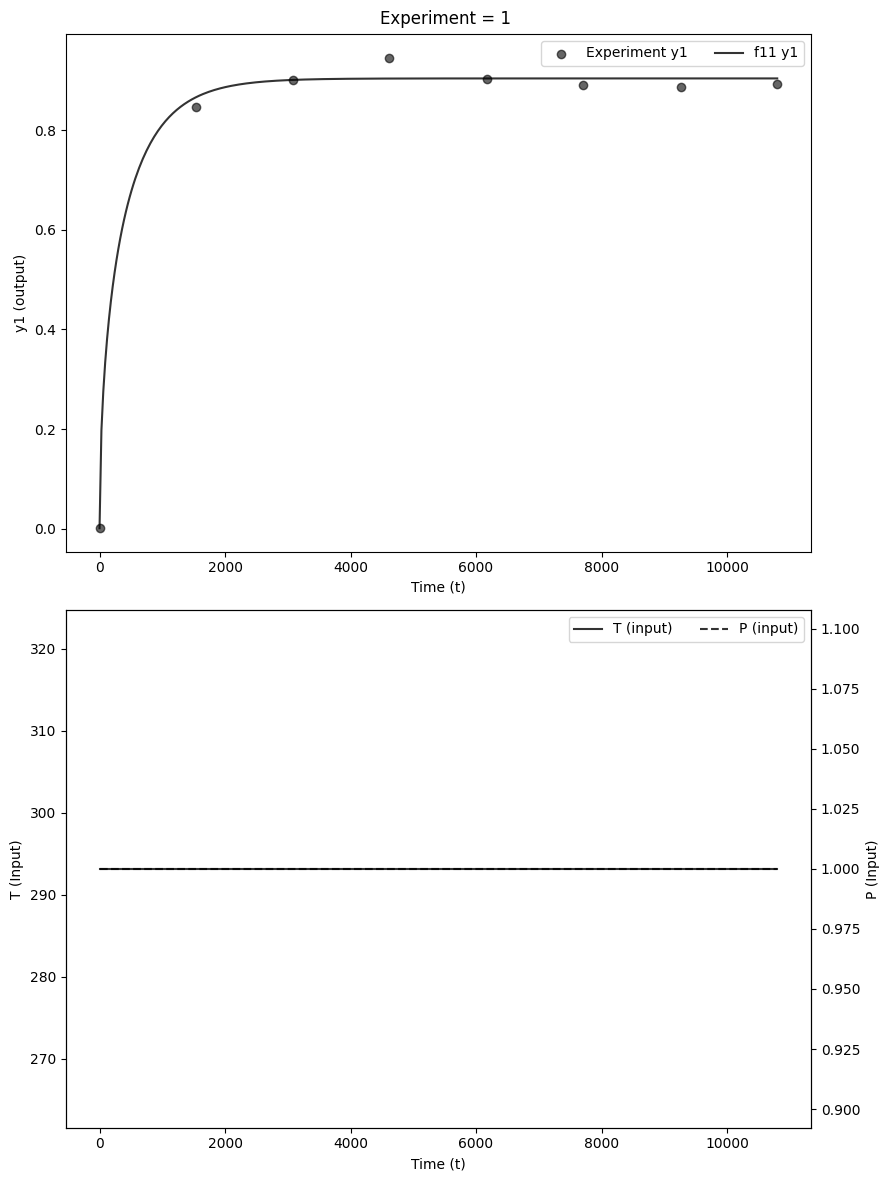

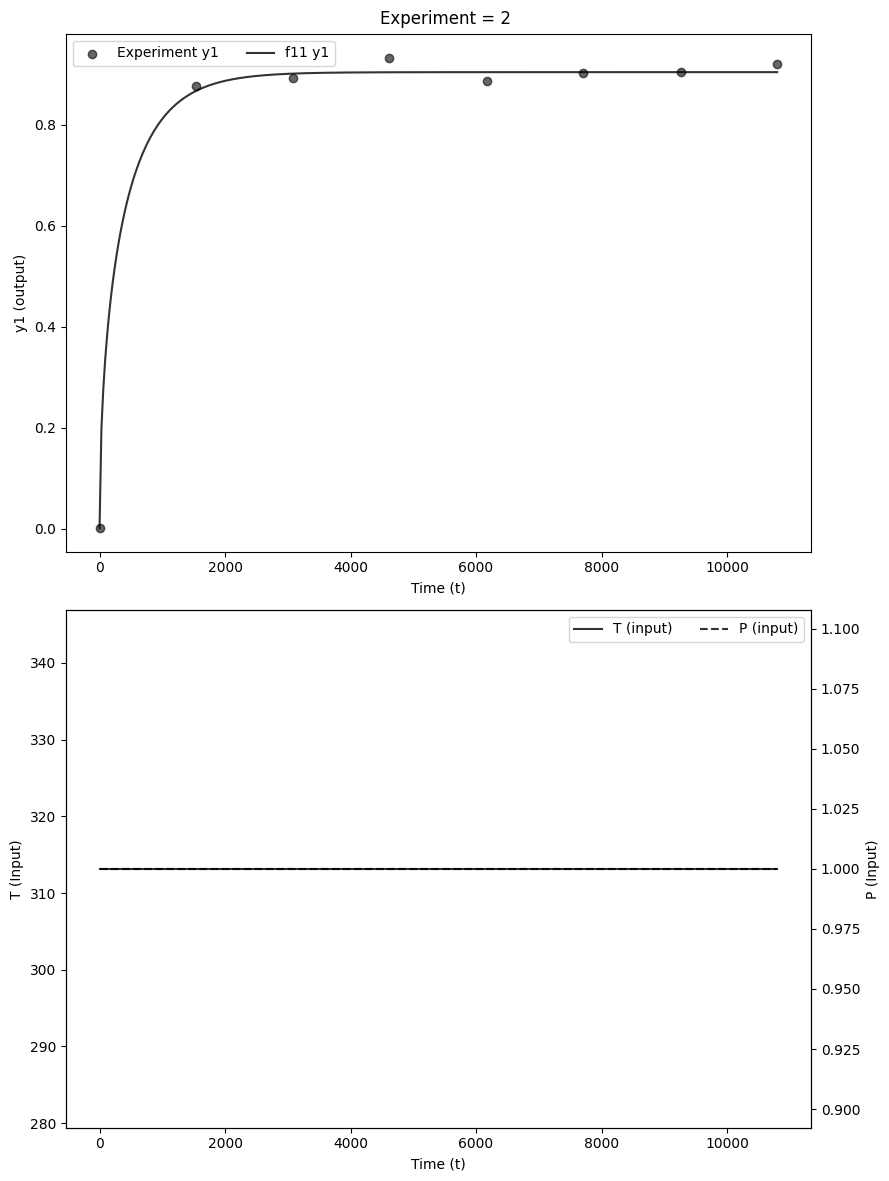

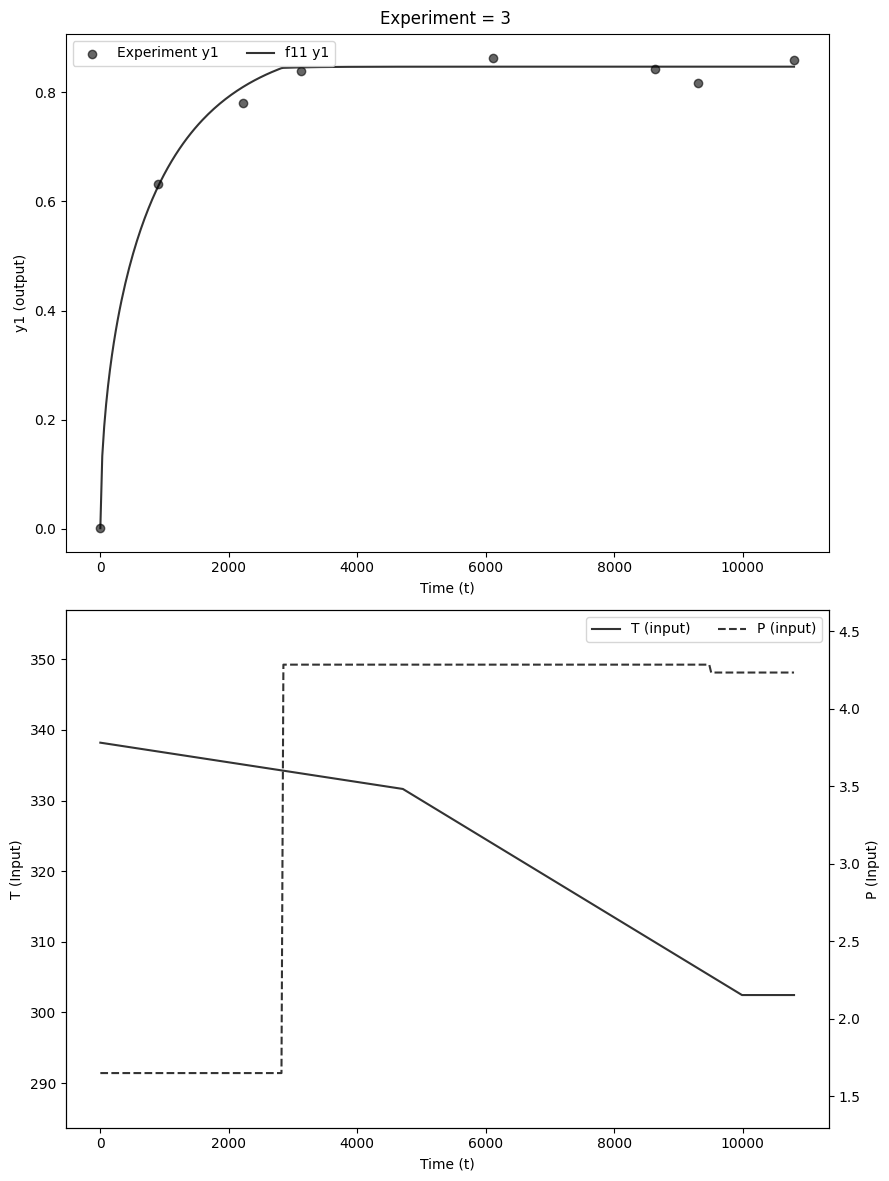

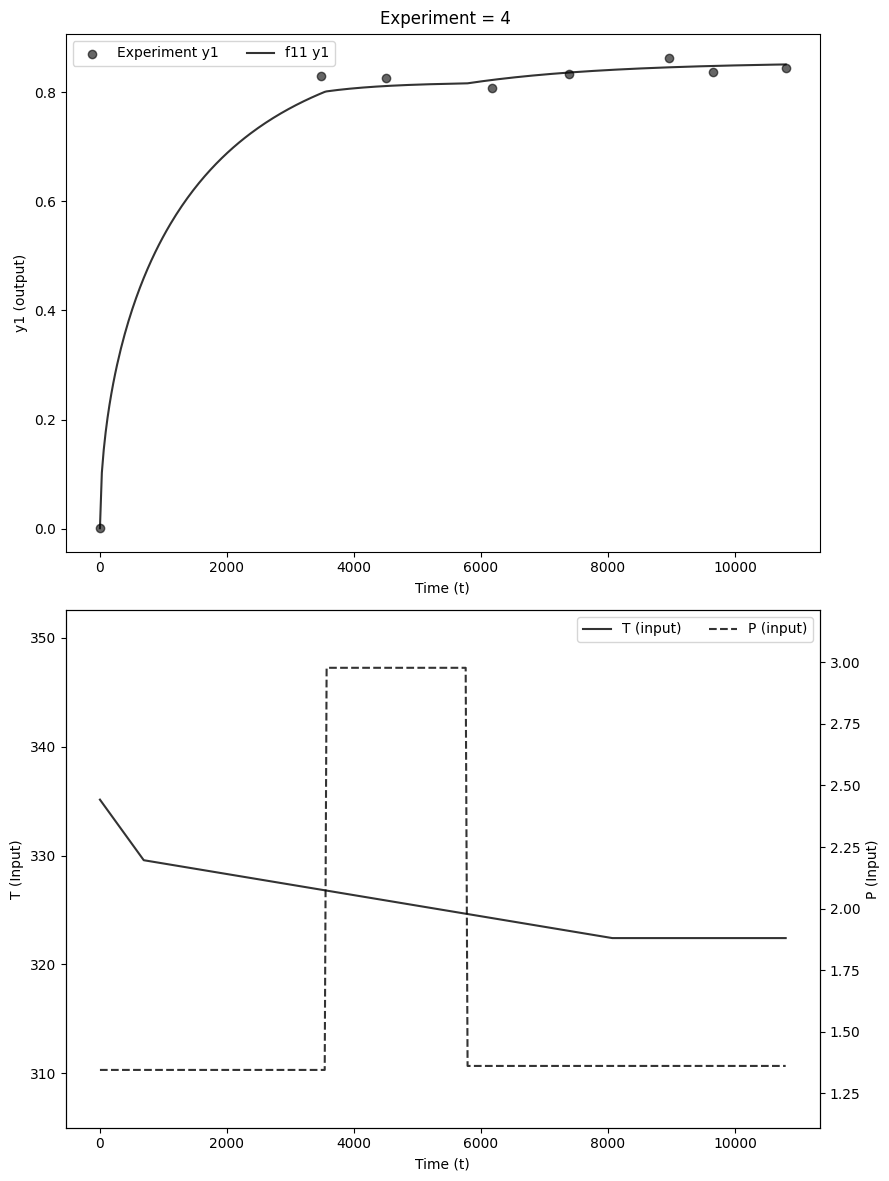

reference t value for model f11 and round 3: 2.045229642132703
estimated t values for model f11 and round 3: [ 0.47818565  3.47764419 46.62907579]
P-value for model f11 and round 3: 100.0
eps for model f11 and round 3: 0.001



{'f11': np.float64(2.045229642132703)}

In [80]:
round = 3
save_rounds(round, resultun, theta_parameters, 'MBDOE_PP', round_data, models, scaled_params, iden_opt,
            solver_parameters, obs, data, system)

In [81]:
save_to_jac(round_data, purpose="iden")


[INFO] Results saved to: C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\iden_results.jac


Running validation fold 1/4...
Validation sheet: 1
Objective function: 'LS'| model 'f11' | CPU time 0.0715 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0665 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0662 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0761 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0675 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0662 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0650 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0777 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0675 seconds.
Objective function: 'LS'| model 'f11' | CPU time 0.0646 seconds.
parameter estimation for model f11 concluded- success: True

Estimated parameters of f11: [3.1770704690074265e-07, 20180.36739136345, 1.2235588992520903]
True parameters of f11: [3.1650075431484574e-07, 20239.398294836665, 1.2133668813455163]
LS objective function value for f11: 0.996962051220346
T

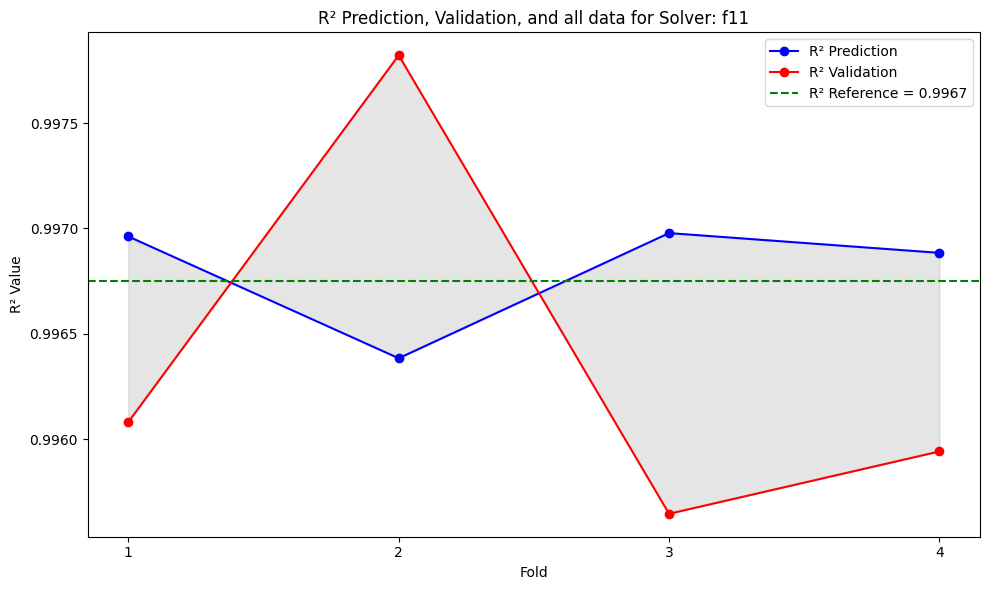

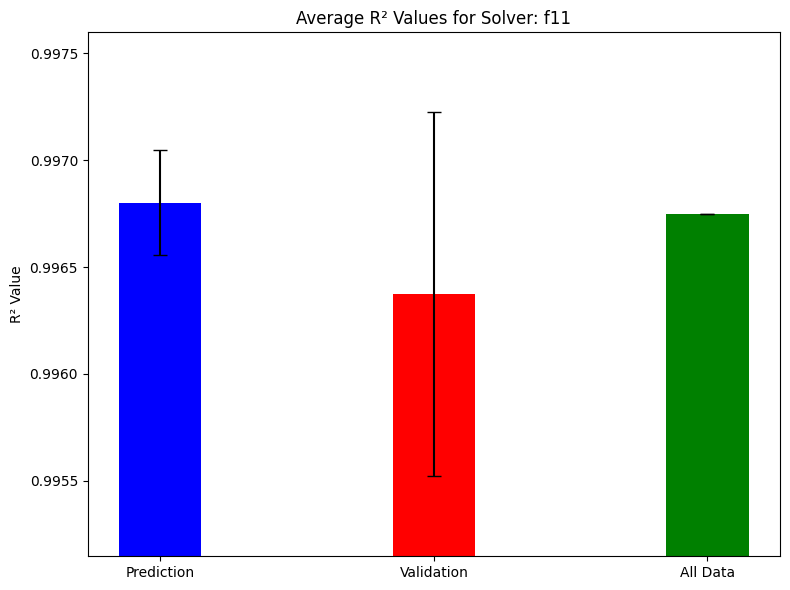

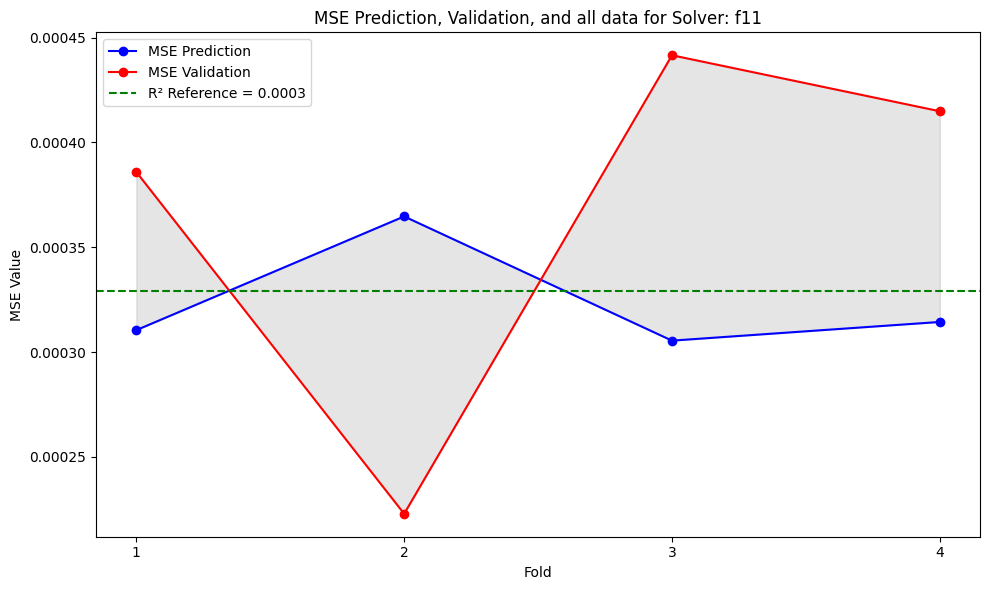

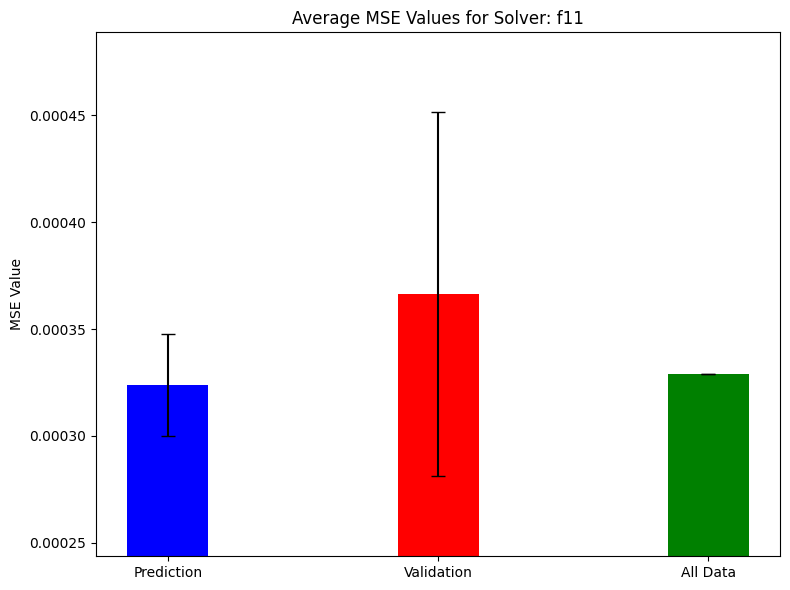

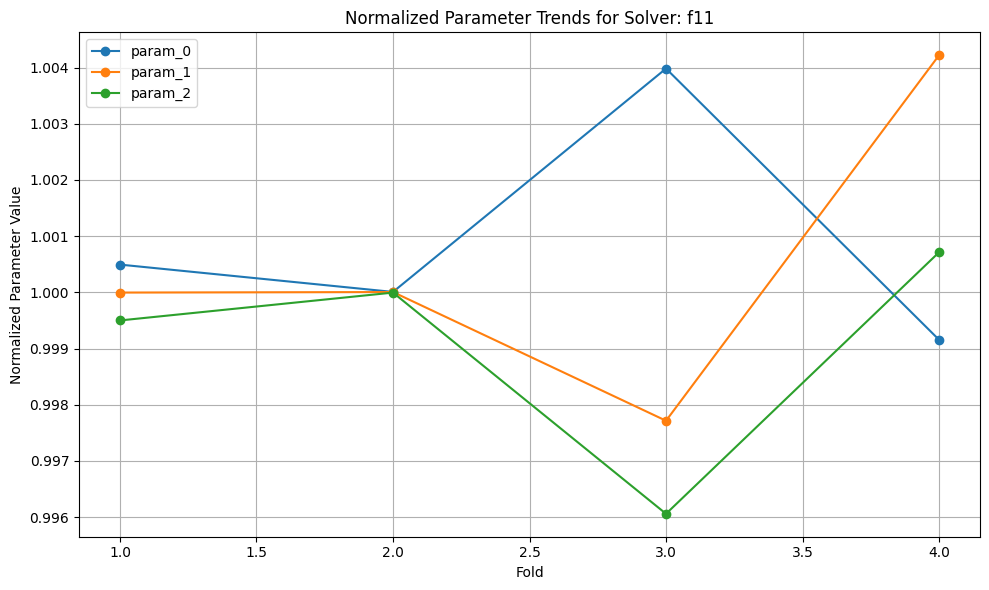

In [82]:
from middoe.iden_valida import validation
R2_prd, R2_val, parameters = validation(data, system, models, iden_opt,round_data)

In [83]:
results = load_from_jac()
iden = results['iden']

Loaded: iden_results.jac
File not found: sensa_results.jac


INFO:middoe.iden_utils:Starting pcomp_plot.


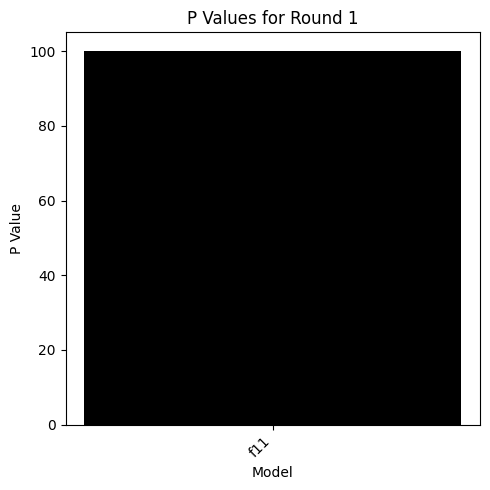

INFO:middoe.iden_utils:P values plot for Round 1 saved to C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\p_values_round_1.png.


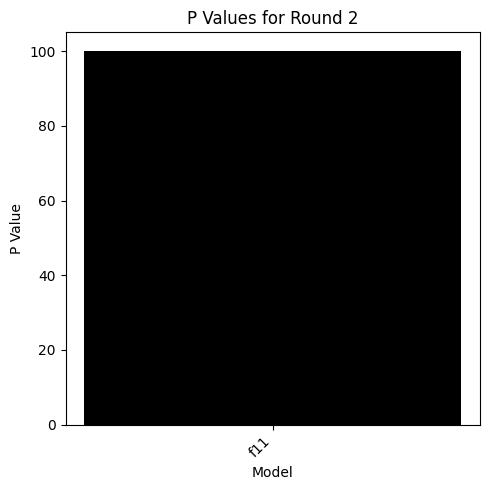

INFO:middoe.iden_utils:P values plot for Round 2 saved to C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\p_values_round_2.png.


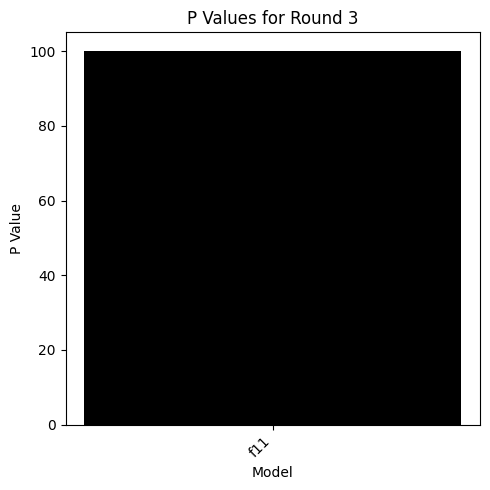

INFO:middoe.iden_utils:P values plot for Round 3 saved to C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\p_values_round_3.png.
INFO:middoe.iden_utils:Starting tcomp_plot.


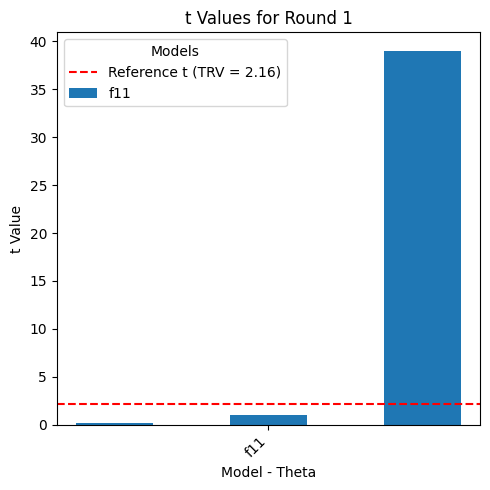

INFO:middoe.iden_utils:T values plot for Round 1 saved to C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\t_values_round_1.png.


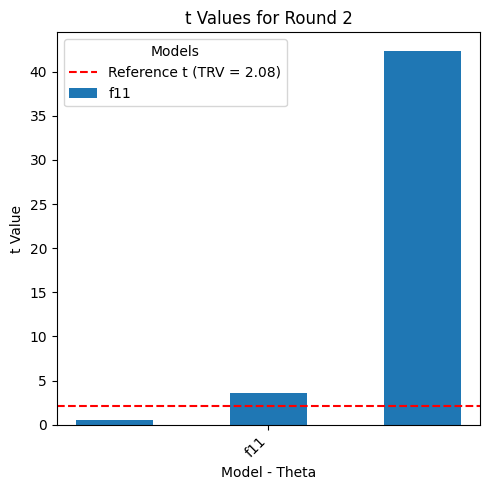

INFO:middoe.iden_utils:T values plot for Round 2 saved to C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\t_values_round_2.png.


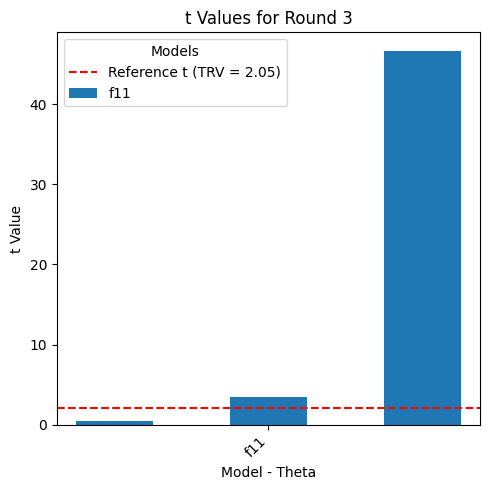

INFO:middoe.iden_utils:T values plot for Round 3 saved to C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\t_values_round_3.png.


Post-processing model: f11


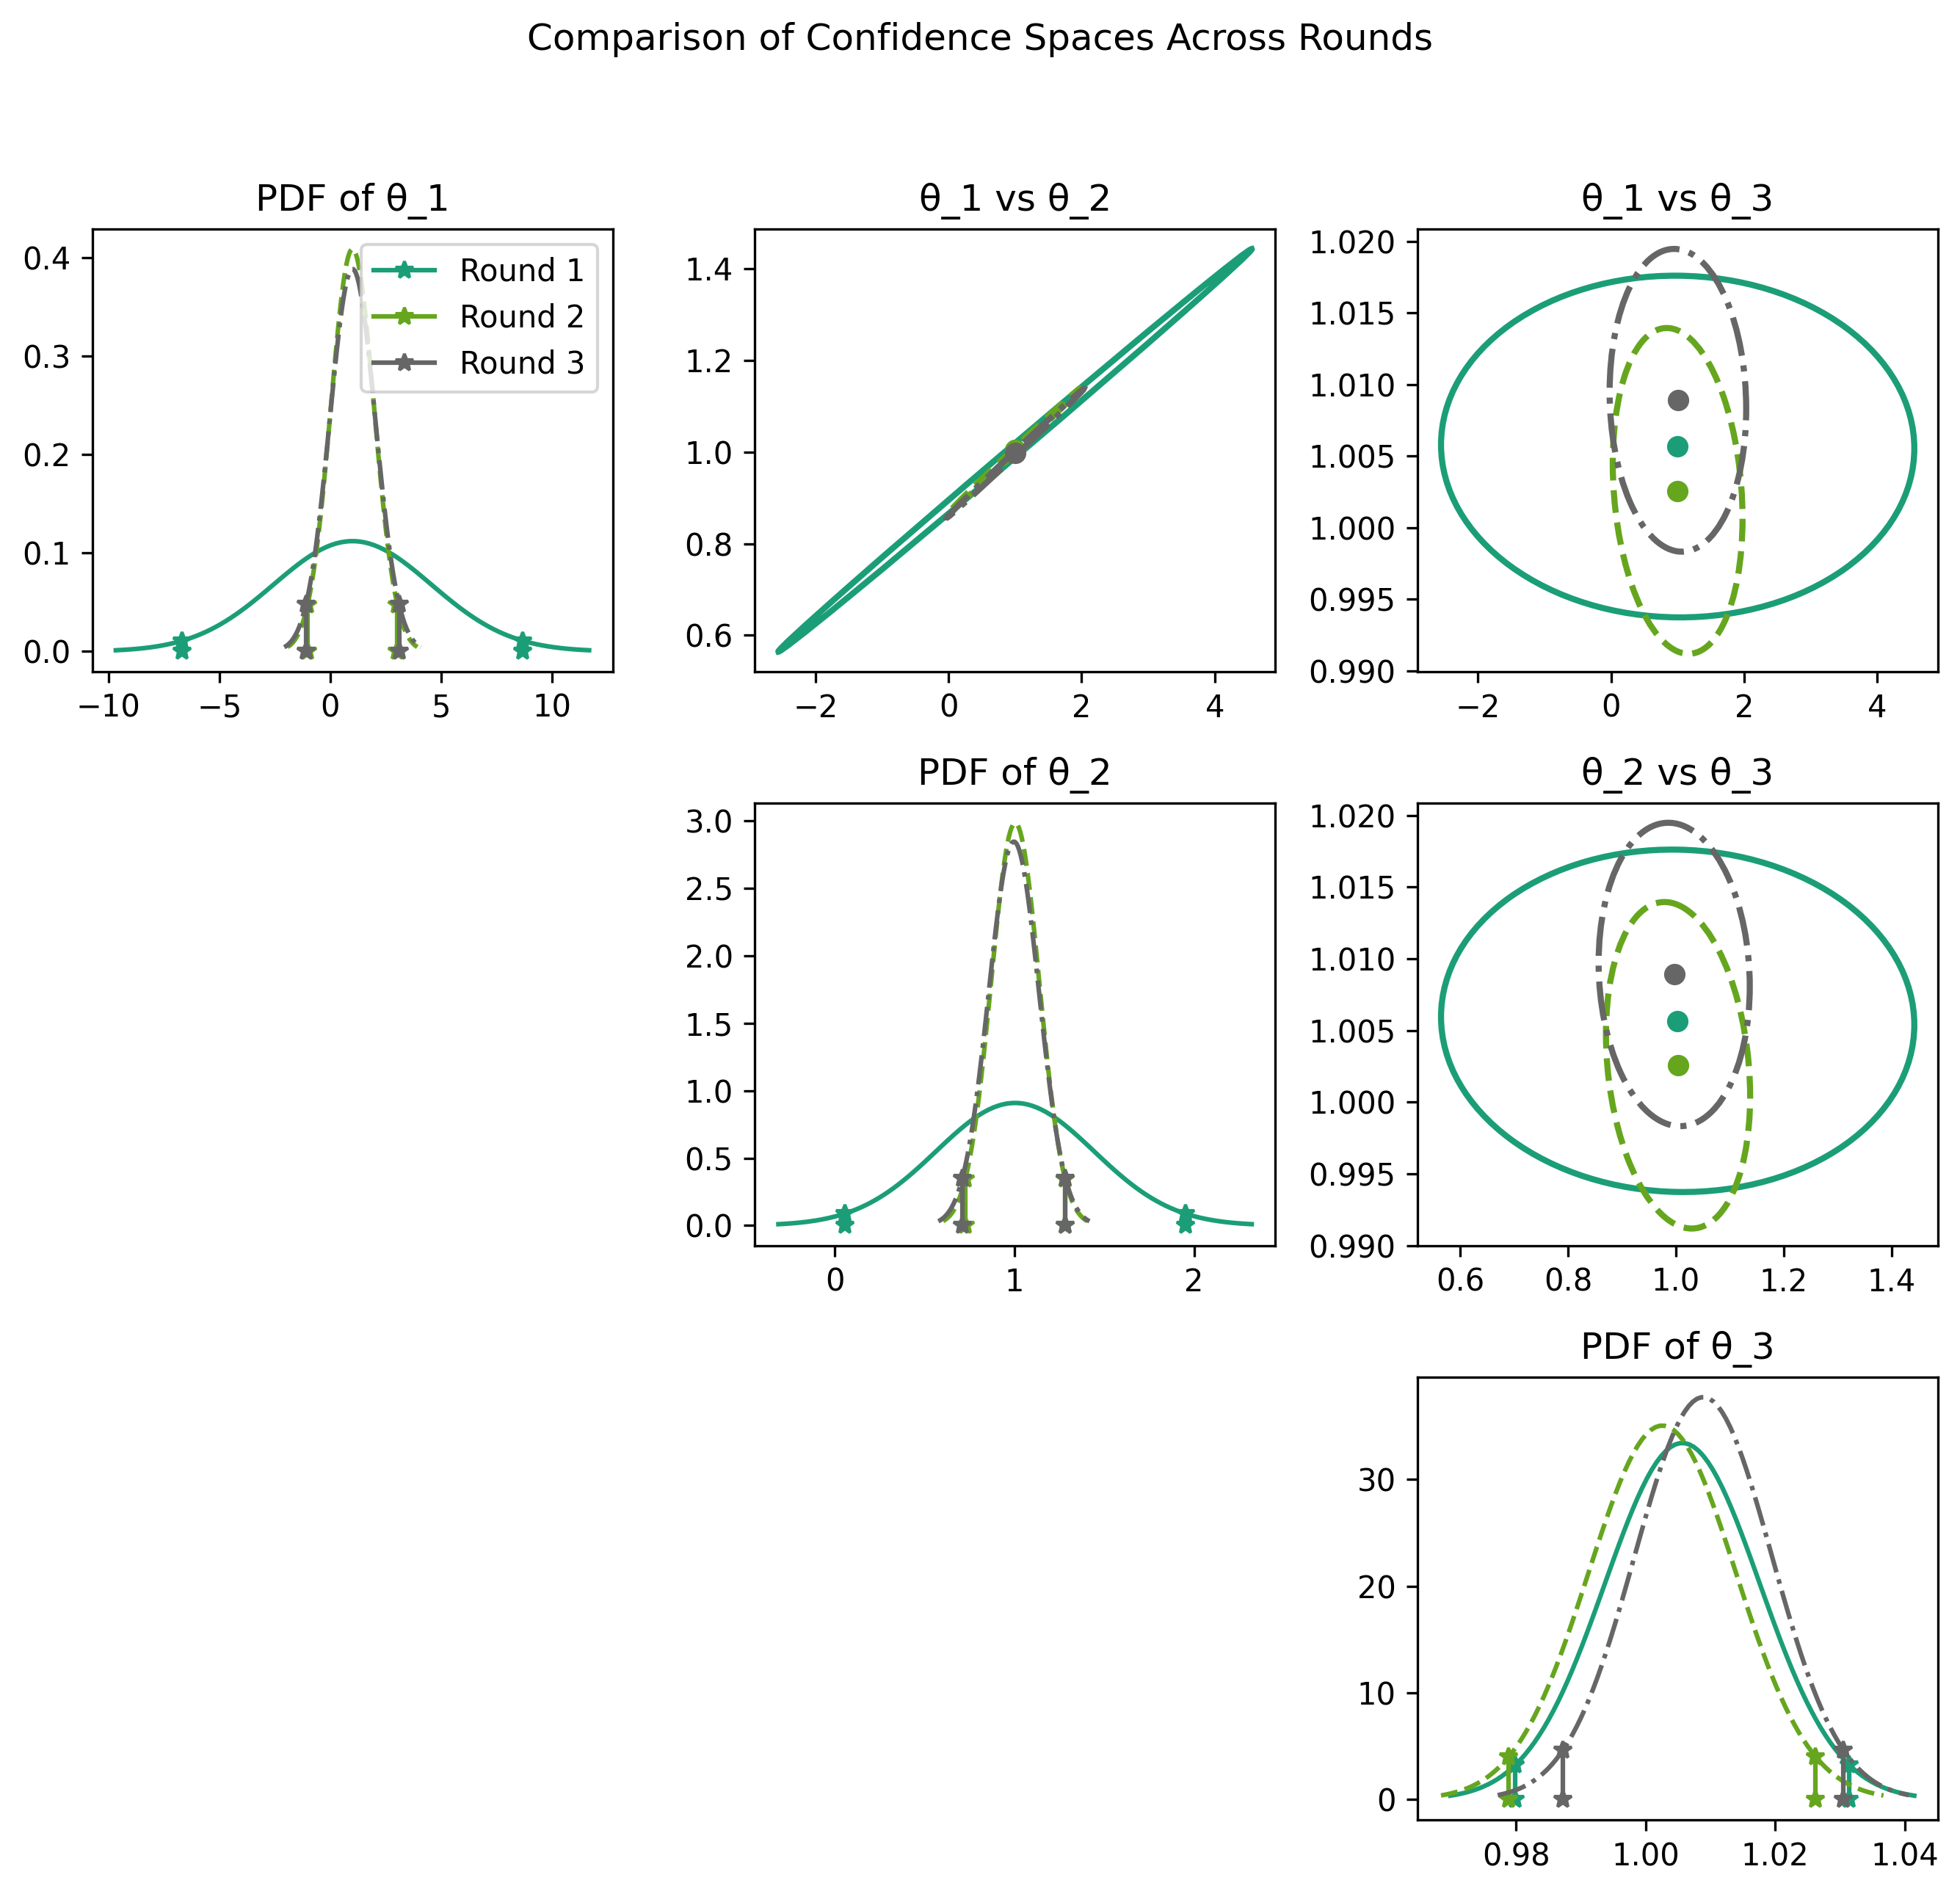

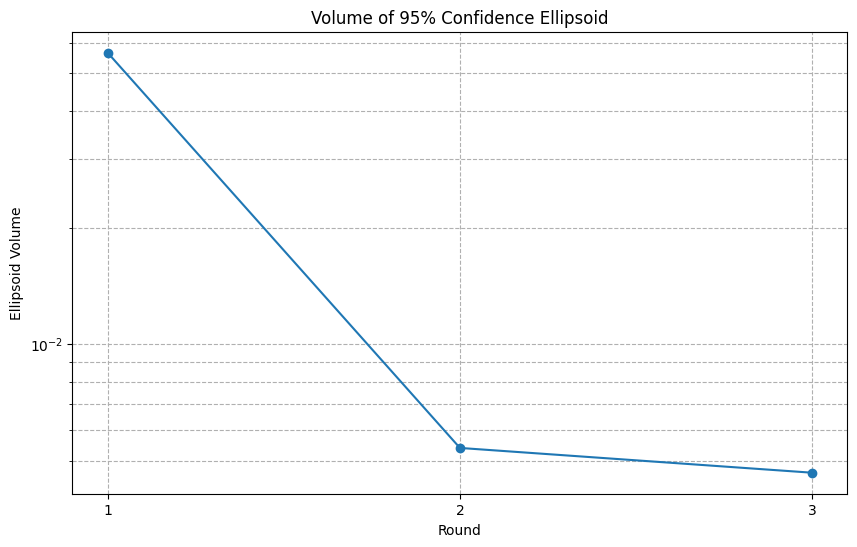

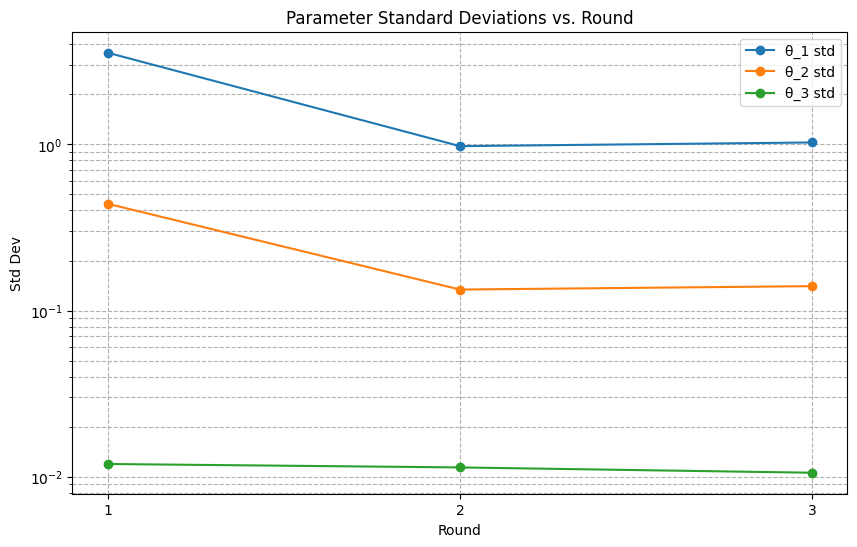

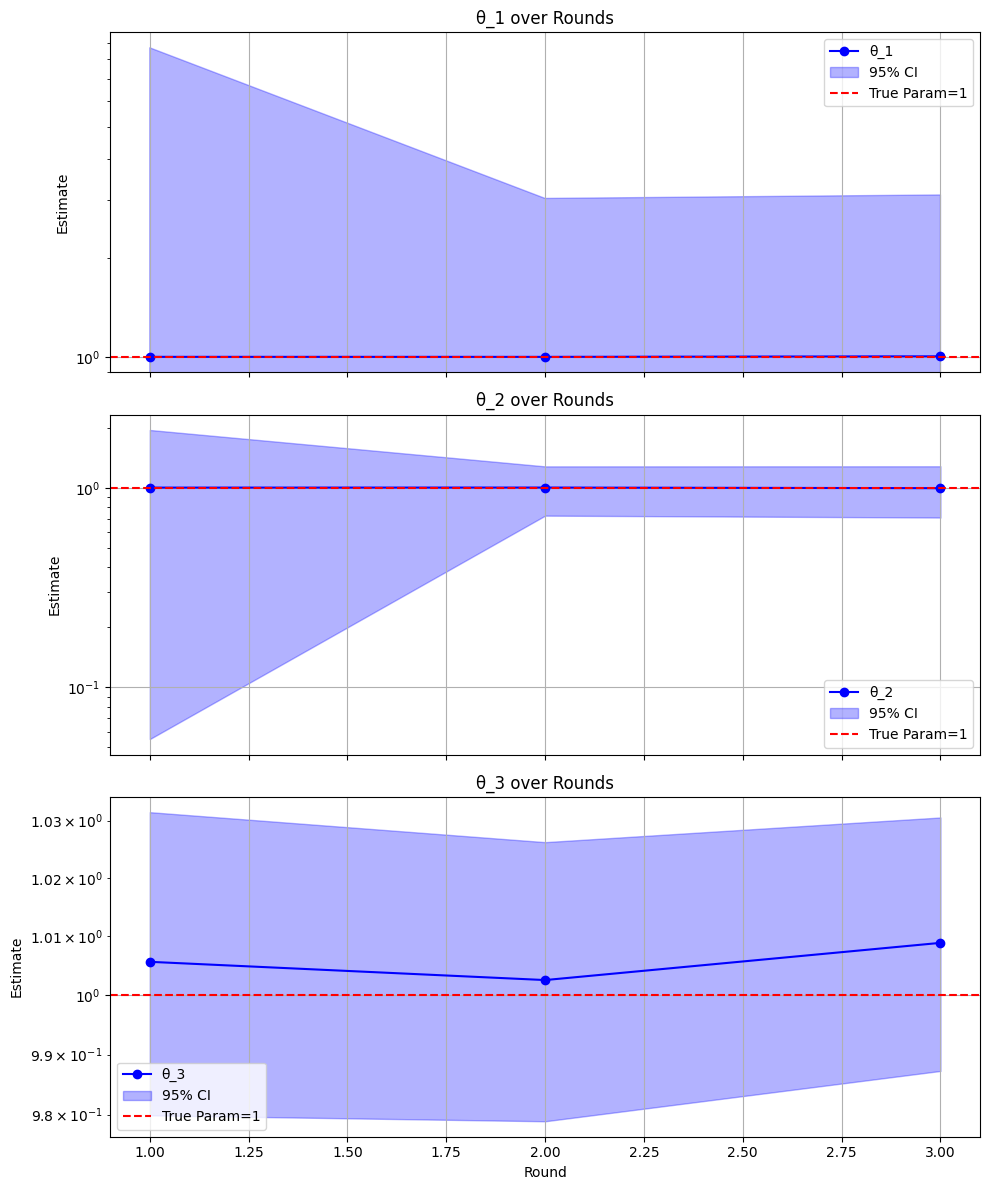

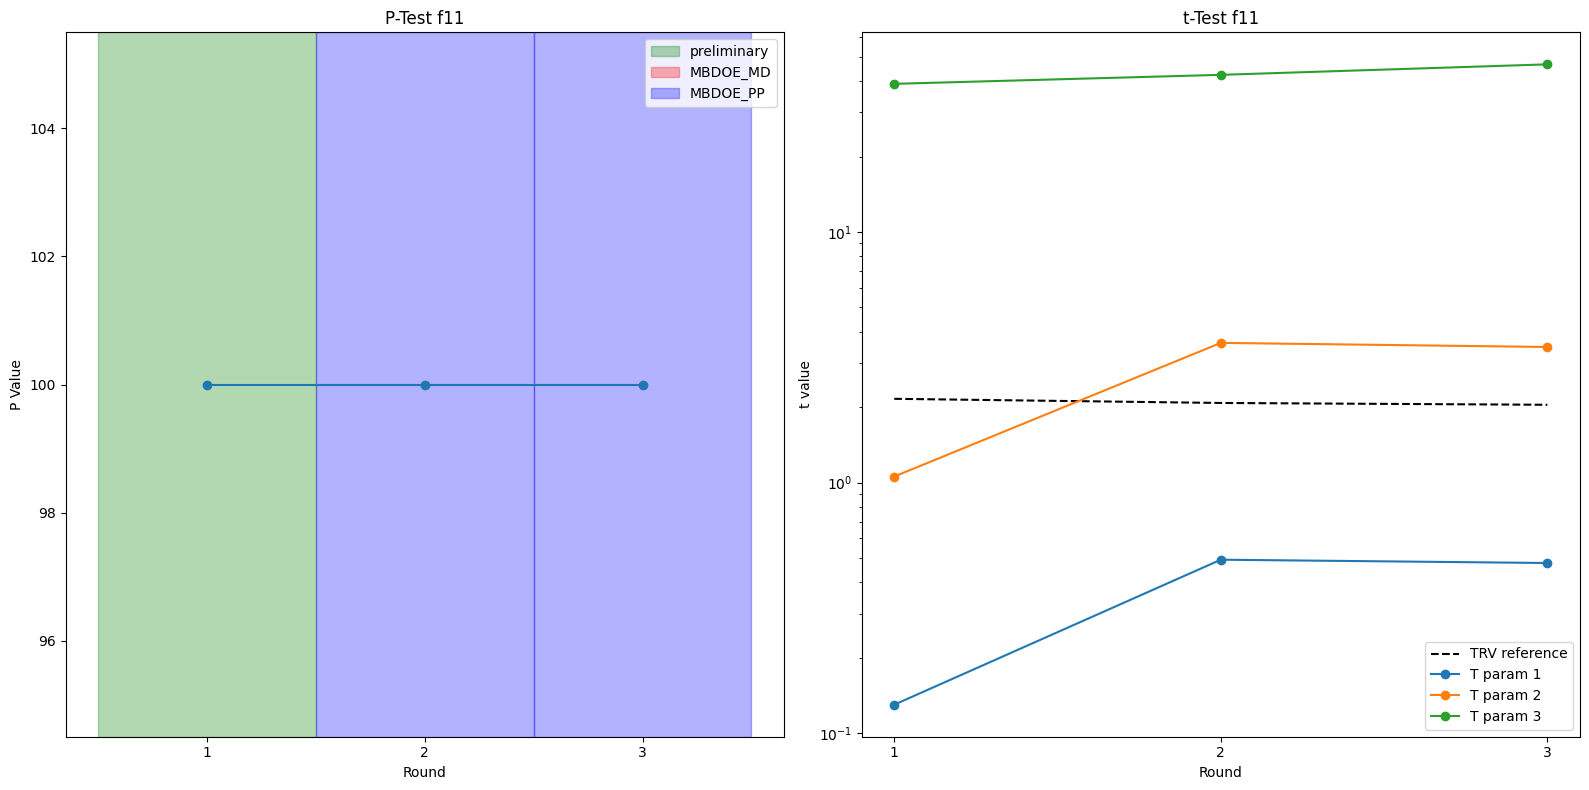

INFO:middoe.iden_utils:Reporter wrote data for Round 1 to 'C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\f11_report_1.xlsx'.
INFO:middoe.iden_utils:Reporter wrote data for Round 2 to 'C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\f11_report_2.xlsx'.
INFO:middoe.iden_utils:Reporter wrote data for Round 3 to 'C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\f11_report_3.xlsx'.
INFO:middoe.iden_utils:Summary written to 'C:\Users\Tadmin\PycharmProjects\tutorialmid1\wetcarbokin\ipy\post_processing\f11_report_summary.txt'.


No rCC_values found for any round. Plotting is skipped.
Post-processing completed for: f11


In [84]:
from middoe.iden_utils import run_postprocessing
run_postprocessing(
    round_data=results['iden'],
    solvers=['f11'],
    selected_rounds=[ 1, 2, 3],
    plot_global_p_and_t=True,
    plot_confidence_spaces=True,
    plot_p_and_t_tests=True,
    export_excel_reports=True,
    plot_estimability=True
)